In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('paper')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.style.use('seaborn')


In [245]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))




file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)

bathy_file = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
Z = bathy_file.variables['Bathymetry'][180:350, 480:650]

In [32]:
path_of_file = '/data/ssahu/Falkor_2013/mvp/'

survey_file_A = path_of_file + 'surveyA.mat'
survey_file_B = path_of_file + 'surveyB.mat'
survey_file_D = path_of_file + 'surveyD.mat'
survey_file_E = path_of_file + 'surveyE.mat'
survey_file_G = path_of_file + 'surveyG.mat'

survey_file = [survey_file_A, survey_file_B, survey_file_D, survey_file_E, survey_file_G]

In [33]:
file = survey_file_E



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [5]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [6]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

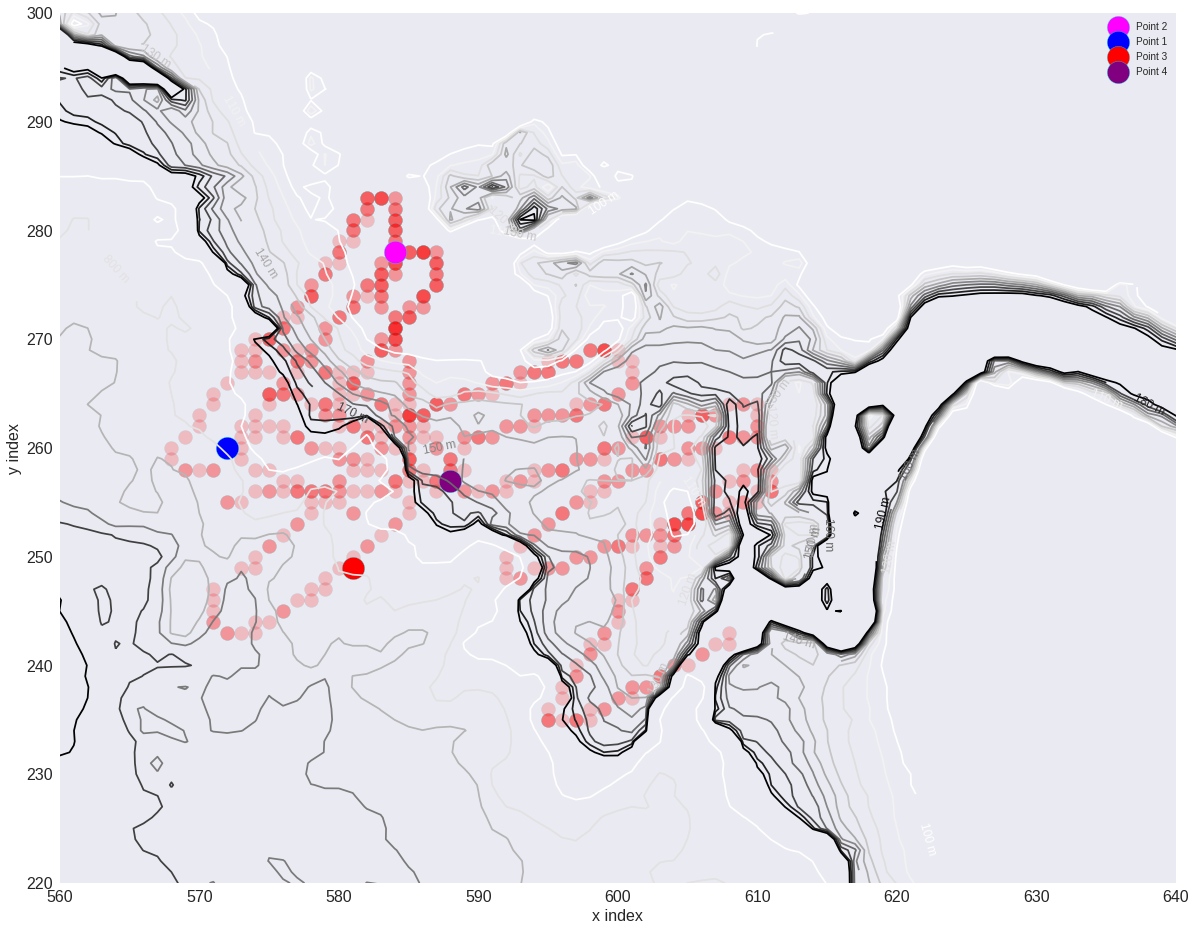

In [16]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[500])], y_wcvi_slice[np.int(q[500])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )

ax.scatter(x_wcvi_slice[np.int(p[420])], y_wcvi_slice[np.int(q[420])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )    

# ax.scatter(x_wcvi_slice[np.int(p[220])], y_wcvi_slice[np.int(q[220])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' )    

ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.scatter(x_wcvi_slice[np.int(p[552])], y_wcvi_slice[np.int(q[552])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [11]:

np.where((y_wcvi_slice[q[:]]>250) & (y_wcvi_slice[q[:]]<260) & (x_wcvi_slice[p[:]]>580) & (x_wcvi_slice[p[:]]<593))

(array([218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 543, 544,
        545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 611,
        612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 650,
        651, 653, 654, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699,
        700, 701]),)

In [233]:
i1 = 420
i2 = 500

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [234]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 1 and 2 (Upstream of Barkley Canyon)


(-0.003, 0.003)

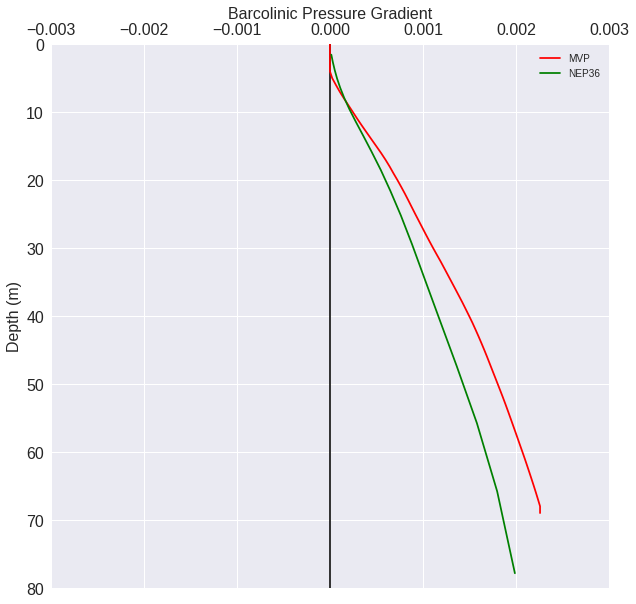

In [235]:
print("Between points 1 and 2 (Upstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,80)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.003,0.003)

In [17]:
i1 = 688
i2 = 552 #220

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [18]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 3 and 4 (Downstream of Barkley Canyon)


(-0.0035, 0.0035)

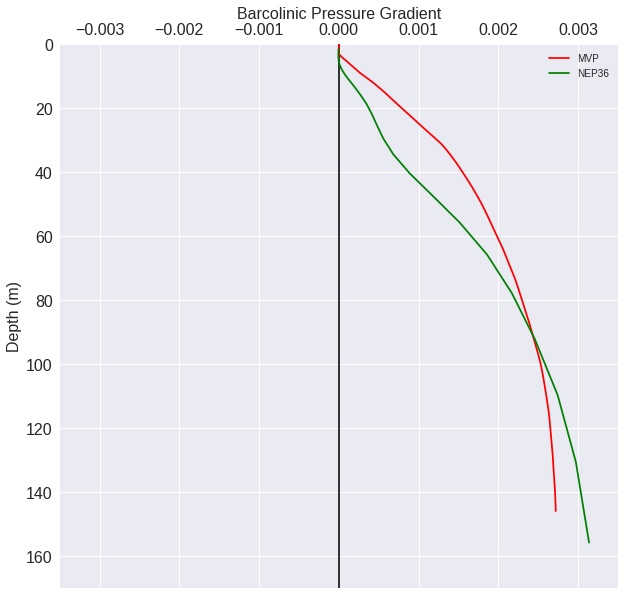

In [19]:
print("Between points 3 and 4 (Downstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

### Slightly mistaken cross shore direction yielded the plot below

Between points 3 and 4 (Downstream of Barkley Canyon)


(-0.0035, 0.0035)

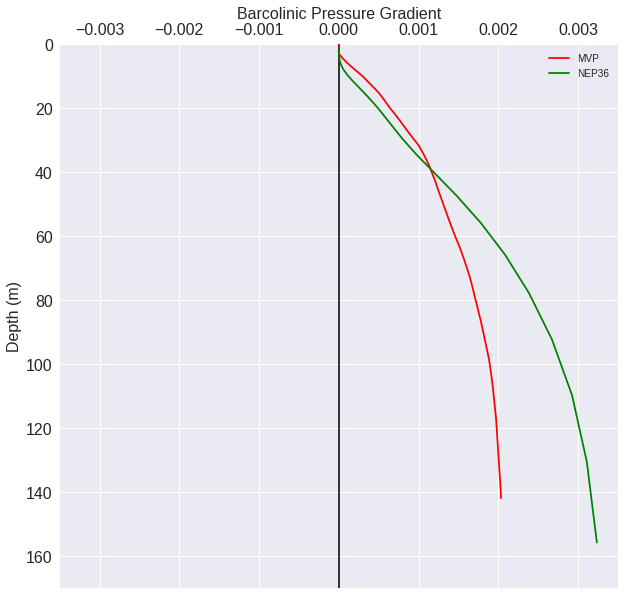

In [238]:
print("Between points 3 and 4 (Downstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

In [17]:
file = survey_file_D



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [18]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [19]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

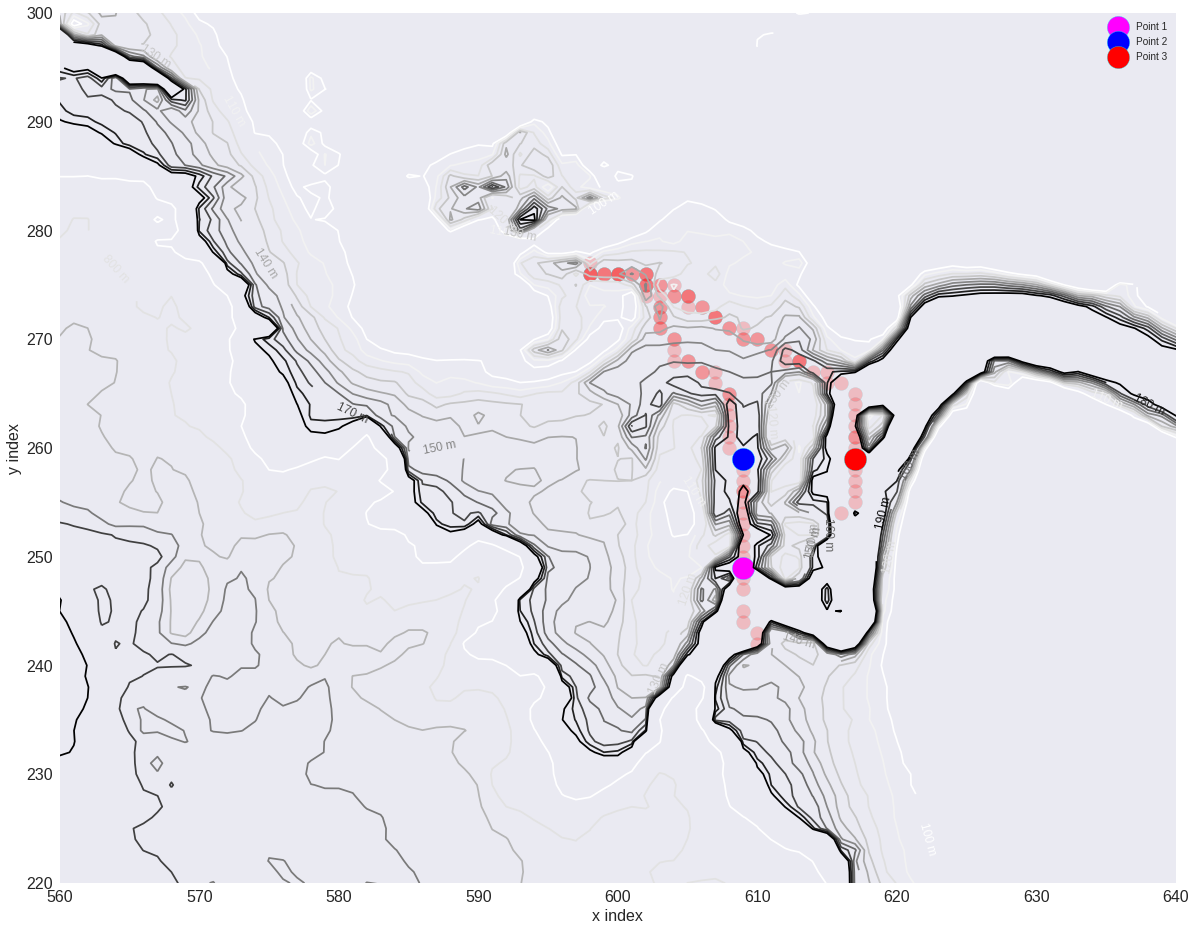

In [56]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[101])], y_wcvi_slice[np.int(q[101])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )

ax.scatter(x_wcvi_slice[np.int(p[90])], y_wcvi_slice[np.int(q[90])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )    

ax.scatter(x_wcvi_slice[np.int(p[5])], y_wcvi_slice[np.int(q[5])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' )    

# ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [23]:

np.where((y_wcvi_slice[q[:]]>250) & (y_wcvi_slice[q[:]]<260) & (x_wcvi_slice[p[:]]>610) & (x_wcvi_slice[p[:]]<620))

(array([0, 1, 2, 3, 4, 5]),)

In [20]:
i1 = 101
i2 = 90

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [32]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


### Between points 1 and 2

Between points 1 and 2 (Through the Tully Canyon)


(-0.0035, 0.0035)

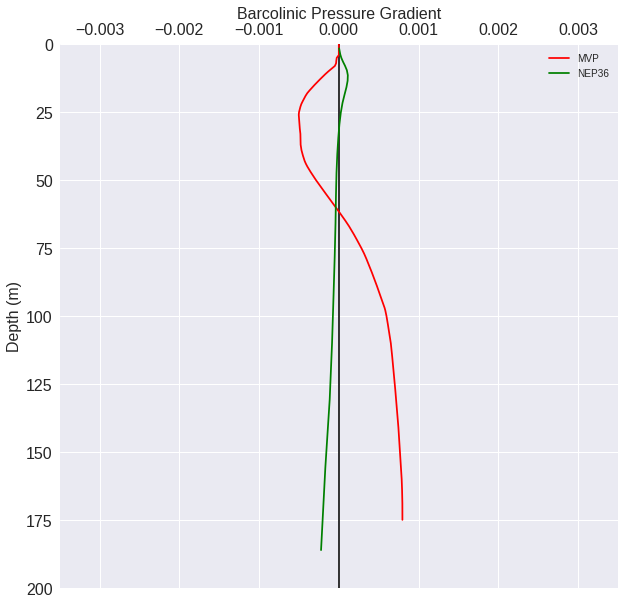

In [33]:
print("Between points 1 and 2 (Through the Tully Canyon)")

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

In [21]:
i1 = 90
i2 = 5

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [28]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 2 and 3 (Through the Tully Canyon)


(-0.0035, 0.0035)

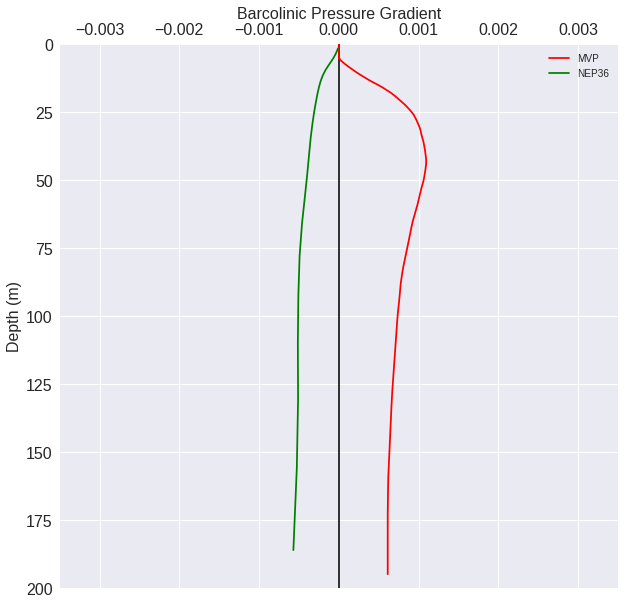

In [30]:
print("Between points 2 and 3 (Through the Tully Canyon)")

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

### Observation: Almost uniform with depth ??

In [3]:
u_vel_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_U_20130817-20130826.nc')
v_vel_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_V_20130817-20130826.nc')

u_vel_slice_date = u_vel_file.variables['uo'][7,:,1:,1:]
v_vel_slice_date = v_vel_file.variables['vo'][7,:,1:,1:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


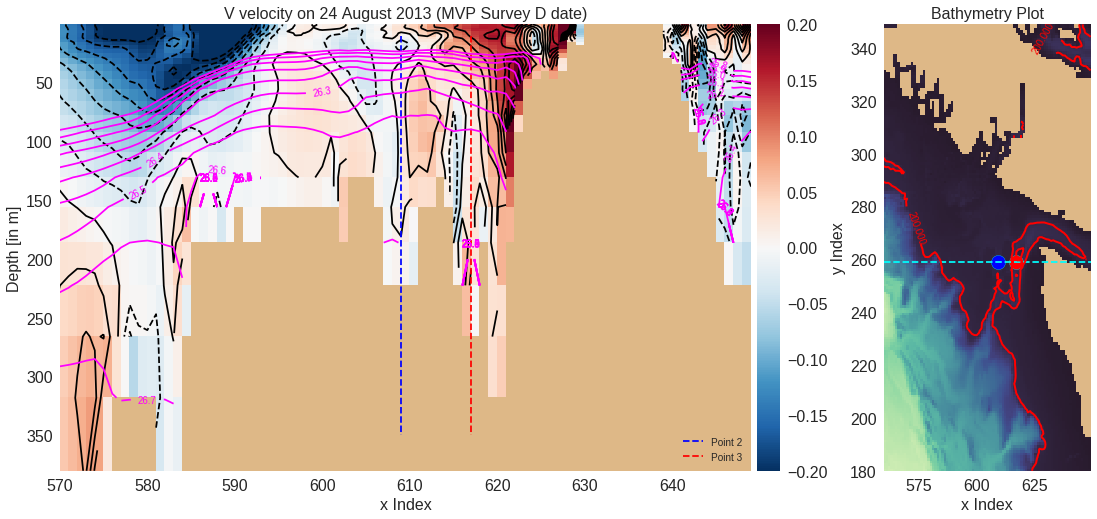

In [116]:
t = 118


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))

land_colour = 'burlywood'

axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[...], cmap=cmap, vmin=0)

# axr.scatter(x_wcvi_slice[np.int(p[i1])], y_wcvi_slice[np.int(q[i1])], c = 'cyan', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'NEP36 Point' )    

legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot', fontsize = 16)
axr.set_xlabel('x Index', fontsize = 16)
axr.set_ylabel('y Index', fontsize = 16)
axr.set_xlim(560)
axr.hlines(y_wcvi_slice[np.int(q[i1])], xmin = 560, xmax = 650, linestyles= 'dashed', colors='cyan')
axr.scatter(x_wcvi_slice[np.int(p[90])], y_wcvi_slice[np.int(q[90])], c = 'blue', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'Point 2' )    

axr.scatter(x_wcvi_slice[np.int(p[5])], y_wcvi_slice[np.int(q[5])], c = 'red', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'Point 3' )    

CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[...], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_vel_slice_date[:,:,:]
v_masked = np.ma.array(v_0, mask =1- vmask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,q[i1],:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
# cbar.set_label('V Velocity', fontsize = 16)
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,q[i1],:], np.arange(-0.2, 0.2, 0.03), colors='black')
# axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlim(570)
axl.set_xlabel('x Index', fontsize = 16)
axl.set_ylabel('Depth [in m]', fontsize = 16)
axl.set_sketch_params('paper')
axl.vlines(x_wcvi_slice[p[i1]], ymin = 10, ymax = 350, linestyles= 'dashed', colors='blue', label = 'Point 2')
axl.vlines(x_wcvi_slice[p[i2]], ymin = 10, ymax = 350, linestyles= 'dashed', colors='red', label = 'Point 3')
axl.set_title('V velocity on 24 August 2013 (MVP Survey D date)', fontsize = 16)
axl.legend(loc = 'lower right')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.tick_params(axis='both',labelsize =16)

axcb.tick_params(axis='both',labelsize =16)

axr.tick_params(axis='both',labelsize =16)
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')

rho_0 = rho[t,:,:,:]
rho_tzyx = np.ma.array(rho_0, mask = 1 - tmask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,q[i1],:] - 1000,np.arange(25.8, 26.8, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)

plt.show()

In [3]:
A1_data = pd.read_table('/data/ssahu/IOS_data/ADCP_E1_A1/a1_20130707_20140524_0498m.csv',delim_whitespace=1,header = None, skiprows=426)

str_stuff = np.array(['Record_Number', 'Date', 'Time', 'Pitch', 'Roll', 'Heading', 'Pressure', 'Temperature'], dtype = 'str')

bin_depths = np.array([84.44, 100.44, 116.44, 132.44, 148.44, 164.44, 180.44, 196.44, 212.44, 228.44, 244.44, 260.44, 276.44\
              , 292.44, 308.44, 324.44, 340.44, 356.44, 372.44, 388.44, 404.44, 420.44, 436.44, 452.44, 468.44], dtype = 'str')

variables = np.array(['vel_north', 'vel_east', 'vel_vert', 'back_scatter_mean'], dtype = 'str')

column_data = []

for j in bin_depths:
    for i in variables:
        column_data = np.append(arr=column_data, values=i+'_'+j)
    

columns_A1 = np.concatenate((str_stuff, column_data), axis = 0)

A1_data.columns = columns_A1

In [4]:
vel_north_84 = np.array(A1_data['vel_north_84.44'], dtype = np.float)[:5284]
vel_east_84  = np.array(A1_data['vel_east_84.44'], dtype = np.float)[:5284]
mag_84       = np.sqrt(vel_east_84**2+vel_north_84**2)
mag_84[mag_84 > 2] = 'Nan'

vel_north_100= np.array(A1_data['vel_north_100.44'], dtype = np.float)[:5284]
vel_east_100 = np.array(A1_data['vel_east_100.44'], dtype = np.float)[:5284]
mag_100       = np.sqrt(vel_east_100**2+vel_north_100**2)
mag_100[mag_100 > 2] = 'Nan'

vel_north_116 = np.array(A1_data['vel_north_116.44'], dtype = np.float)[:5284]
vel_east_116  = np.array(A1_data['vel_east_116.44'], dtype = np.float)[:5284]
mag_116       = np.sqrt(vel_east_116**2+vel_north_116**2)
mag_116[mag_116 > 2] = 'Nan'

vel_north_148 = np.array(A1_data['vel_north_148.44'], dtype = np.float)[:5284]
vel_east_148  = np.array(A1_data['vel_east_148.44'], dtype = np.float)[:5284]
mag_148       = np.sqrt(vel_east_148**2+vel_north_148**2)

vel_north_164= np.array(A1_data['vel_north_164.44'], dtype = np.float)[:5284]
vel_east_164 = np.array(A1_data['vel_east_164.44'], dtype = np.float)[:5284]
mag_164       = np.sqrt(vel_east_164**2+vel_north_164**2)
mag_164[mag_164 > 2] = 'Nan'

vel_north_180= np.array(A1_data['vel_north_180.44'], dtype = np.float)[:5284]
vel_east_180 = np.array(A1_data['vel_east_180.44'], dtype = np.float)[:5284]
mag_180       = np.sqrt(vel_east_180**2+vel_north_180**2)
mag_180[mag_180 > 2] = 'Nan'

vel_north_196 = np.array(A1_data['vel_north_196.44'], dtype = np.float)[:5284]
vel_east_196  = np.array(A1_data['vel_east_196.44'], dtype = np.float)[:5284]
mag_196      = np.sqrt(vel_east_196**2+vel_north_196**2)

vel_north_228 = np.array(A1_data['vel_north_228.44'], dtype = np.float)[:5284]
vel_east_228 = np.array(A1_data['vel_east_228.44'], dtype = np.float)[:5284]
mag_228      = np.sqrt(vel_east_228**2+vel_north_228**2)

vel_north_260 = np.array(A1_data['vel_north_260.44'], dtype = np.float)[:5284]
vel_east_260 = np.array(A1_data['vel_east_260.44'], dtype = np.float)[:5284]
mag_260      = np.sqrt(vel_east_260**2+vel_north_260**2)

vel_north_276 = np.array(A1_data['vel_north_276.44'], dtype = np.float)[:5284]
vel_east_276 = np.array(A1_data['vel_east_276.44'], dtype = np.float)[:5284]
mag_276      = np.sqrt(vel_east_276**2+vel_north_276**2)

vel_north_292 = np.array(A1_data['vel_north_292.44'], dtype = np.float)[:5284]
vel_east_292 = np.array(A1_data['vel_east_292.44'], dtype = np.float)[:5284]
mag_292      = np.sqrt(vel_east_292**2+vel_north_292**2)

vel_north_308 = np.array(A1_data['vel_north_308.44'], dtype = np.float)[:5284]
vel_east_308 = np.array(A1_data['vel_east_308.44'], dtype = np.float)[:5284]
mag_308      = np.sqrt(vel_east_308**2+vel_north_308**2)

vel_north_340 = np.array(A1_data['vel_north_340.44'], dtype = np.float)[:5284]
vel_east_340 = np.array(A1_data['vel_east_340.44'], dtype = np.float)[:5284]
mag_340      = np.sqrt(vel_east_340**2+vel_north_340**2)

vel_north_372 = np.array(A1_data['vel_north_372.44'], dtype = np.float)[:5284]
vel_east_372 = np.array(A1_data['vel_east_372.44'], dtype = np.float)[:5284]
mag_372      = np.sqrt(vel_east_372**2+vel_north_372**2)

vel_north_388 = np.array(A1_data['vel_north_388.44'], dtype = np.float)[:5284]
vel_east_388 = np.array(A1_data['vel_east_388.44'], dtype = np.float)[:5284]
mag_388      = np.sqrt(vel_east_388**2+vel_north_388**2)

In [11]:
np.where(mag_84 == np.max(mag_84))

(array([], dtype=int64),)

In [5]:
tarikh = np.array(A1_data['Date'], dtype = np.str)
samai  = np.array(A1_data['Time'], dtype = np.str)

time = np.empty_like(tarikh)

for i in np.arange(tarikh.shape[0]):
    time[i] = tarikh[i] + '' + samai[i]


datetime_A1 = np.empty_like(time)

for i in np.arange(datetime_A1.shape[0]):
    datetime_A1[i] = datetime.strptime(time[i], '%Y/%m/%d%H:%M:%S')
    
datetime_A1 = datetime_A1.astype(np.datetime64)


In [6]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0,vmax=0.4)


cm = plt.get_cmap(cmo.cm.matter)

cm_NEP = plt.get_cmap(cmo.cm.speed)

# cmap.set_bad('Burlywood')

# norm = matplotlib.colors.Normalize()
# norm.autoscale(~np.isnan(mag_84))
# cm = matplotlib.cm.copper

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])



sm_NEP = matplotlib.cm.ScalarMappable(cmap=cm_NEP, norm=norm)
sm_NEP.set_array([])

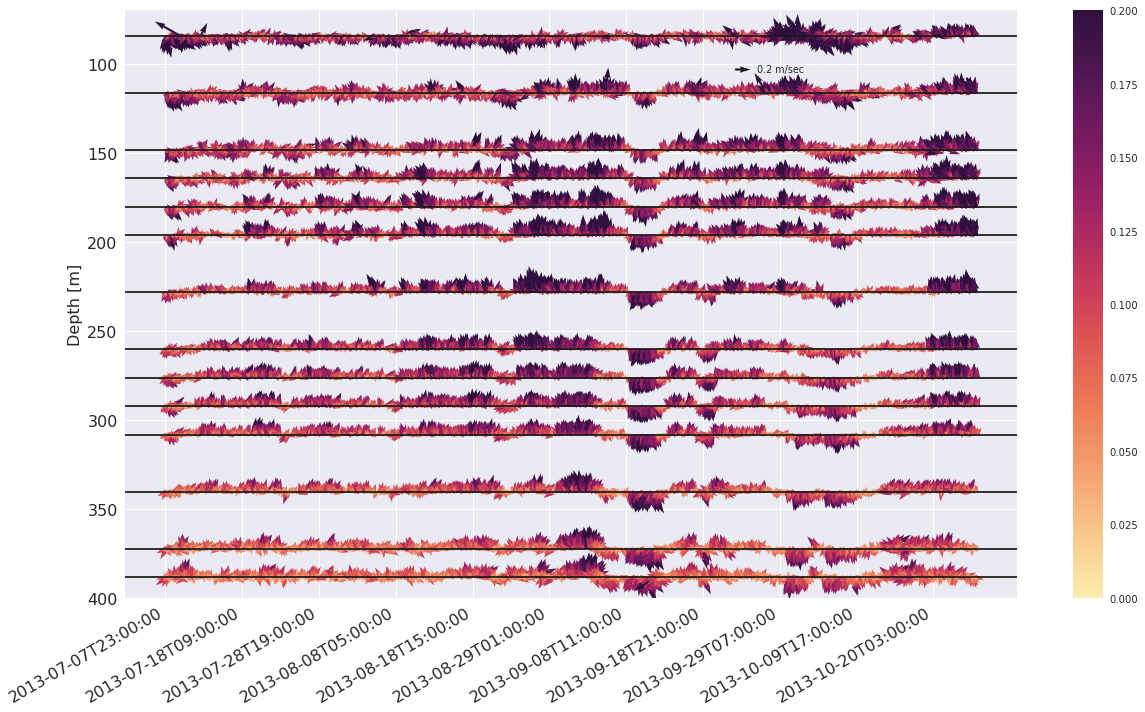

In [84]:
# sns.set()
sns.set_style('dark')
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)





time_axis = datetime_A1[:5284]
time_tick = time_axis[::step]
time_axis_quiver = np.arange(0,5284,step)



fig, ax = plt.subplots(1, 1, figsize=(20,12))


ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', cmap = cm, norm = norm, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=84.44, color='k', label = '84 m')

# ax.quiver(time_axis_quiver, 100.44, vel_east_100[::step], vel_north_100[::step], mag_100[::step], angles='uv', cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
# ax.axhline(y=100.44, color='k', label = '100 m')

ax.quiver(time_axis_quiver, 116.44, vel_east_116[::step], vel_north_116[::step], mag_116[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=116.44, color='k', label = '116 m')

ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=148.44, color='k', label = '148 m')

ax.quiver(time_axis_quiver, 164.44, vel_east_164[::step], vel_north_164[::step], mag_164[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=164.44, color='k', label = '164 m')

ax.quiver(time_axis_quiver, 180.44, vel_east_180[::step], vel_north_180[::step], mag_180[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=180.44, color='k', label = '180 m')

ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=196.44, color='k', label = '196 m')

Q = ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=228.44, color='k', label = '228 m')

ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=260.44, color='k', label = '260 m')

ax.quiver(time_axis_quiver, 276.44, vel_east_276[::step], vel_north_276[::step], mag_276[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=276.44, color='k', label = '276 m')

ax.quiver(time_axis_quiver, 292.44, vel_east_292[::step], vel_north_292[::step], mag_292[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=292.44, color='k', label = '292 m')

ax.quiver(time_axis_quiver, 308.44, vel_east_308[::step], vel_north_308[::step], mag_308[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=308.44, color='k', label = '308 m')

ax.quiver(time_axis_quiver, 340.44, vel_east_340[::step], vel_north_340[::step], mag_340[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=340.44, color='k', label = '340 m')

ax.quiver(time_axis_quiver, 372.44, vel_east_372[::step], vel_north_372[::step], mag_372[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=372.44, color='k', label = '372 m')

ax.quiver(time_axis_quiver, 388.44, vel_east_388[::step], vel_north_388[::step], mag_388[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=388.44, color='k', label = '388 m')


ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver[::500], time_tick[::500], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(70, 400)
ax.invert_yaxis()
ax.tick_params(axis='both',labelsize =16)

ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E', coordinates='axes')
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.colorbar(sm)


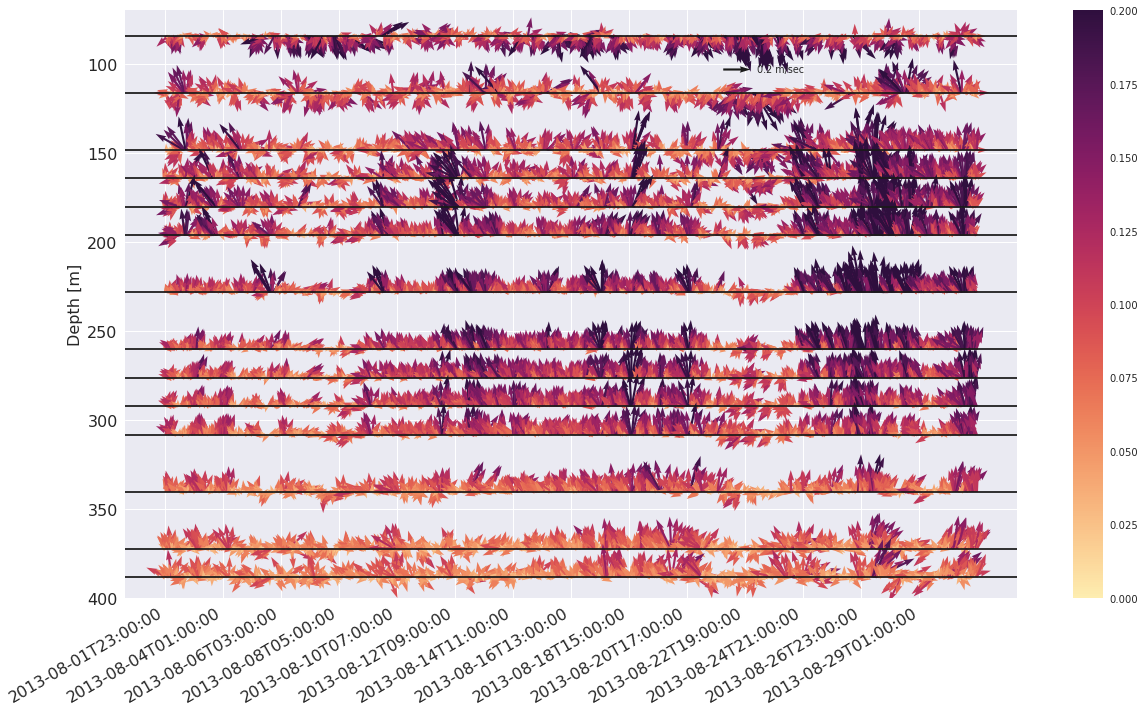

In [44]:
# sns.set()
sns.set_style('dark')
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)





time_axis = datetime_A1[:5284]
time_tick = time_axis[::step]
time_axis_quiver = np.arange(0,5284,step)

time_tick = time_tick[1200:2600]
time_axis_quiver = np.arange(1200,2600,step)





fig, ax = plt.subplots(1, 1, figsize=(20,12))


ax.quiver(time_axis_quiver, 84.44, vel_east_84[1200:2600:step], vel_north_84[1200:2600:step], mag_84[1200:2600:step], angles='uv', cmap = cm, norm = norm, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=84.44, color='k', label = '84 m')

# ax.quiver(time_axis_quiver, 100.44, vel_east_100[::step], vel_north_100[::step], mag_100[::step], angles='uv', cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
# ax.axhline(y=100.44, color='k', label = '100 m')

ax.quiver(time_axis_quiver, 116.44, vel_east_116[1200:2600:step], vel_north_116[1200:2600:step], mag_116[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=116.44, color='k', label = '116 m')

ax.quiver(time_axis_quiver, 148.44, vel_east_148[1200:2600:step], vel_north_148[1200:2600:step], mag_148[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=148.44, color='k', label = '148 m')

ax.quiver(time_axis_quiver, 164.44, vel_east_164[1200:2600:step], vel_north_164[1200:2600:step], mag_164[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=164.44, color='k', label = '164 m')

ax.quiver(time_axis_quiver, 180.44, vel_east_180[1200:2600:step], vel_north_180[1200:2600:step], mag_180[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=180.44, color='k', label = '180 m')

ax.quiver(time_axis_quiver, 196.44, vel_east_196[1200:2600:step], vel_north_196[1200:2600:step], mag_196[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=196.44, color='k', label = '196 m')

Q = ax.quiver(time_axis_quiver, 228.44, vel_east_228[1200:2600:step], vel_north_228[1200:2600:step], mag_228[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=228.44, color='k', label = '228 m')

ax.quiver(time_axis_quiver, 260.44, vel_east_260[1200:2600:step], vel_north_260[1200:2600:step], mag_260[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=260.44, color='k', label = '260 m')

ax.quiver(time_axis_quiver, 276.44, vel_east_276[1200:2600:step], vel_north_276[1200:2600:step], mag_276[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=276.44, color='k', label = '276 m')

ax.quiver(time_axis_quiver, 292.44, vel_east_292[1200:2600:step], vel_north_292[1200:2600:step], mag_292[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=292.44, color='k', label = '292 m')

ax.quiver(time_axis_quiver, 308.44, vel_east_308[1200:2600:step], vel_north_308[1200:2600:step], mag_308[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=308.44, color='k', label = '308 m')

ax.quiver(time_axis_quiver, 340.44, vel_east_340[1200:2600:step], vel_north_340[1200:2600:step], mag_340[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=340.44, color='k', label = '340 m')

ax.quiver(time_axis_quiver, 372.44, vel_east_372[1200:2600:step], vel_north_372[1200:2600:step], mag_372[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=372.44, color='k', label = '372 m')

ax.quiver(time_axis_quiver, 388.44, vel_east_388[1200:2600:step], vel_north_388[1200:2600:step], mag_388[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=388.44, color='k', label = '388 m')


ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver[::100], time_tick[::100], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(70, 400)
ax.invert_yaxis()
ax.tick_params(axis='both',labelsize =16)

ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E', coordinates='axes')
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.colorbar(sm)


In [6]:
mydates = np.array(pd.date_range(datetime_A1[:5284][0], datetime_A1[:5284][-1], freq="30min"))

In [7]:
A1_series_east = pd.Series(vel_east_84, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)


A1_series_east = pd.Series(vel_east_148, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)

A1_series_east = pd.Series(vel_east_308, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_308_daily_east = daily_east.values
east_308 = np.divide(vel_308_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_308, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_308_daily_north = daily_north.values
north_308 = np.divide(vel_308_daily_north[:], 24)

Speed_308 = np.sqrt(east_308**2 + north_308**2)


A1_series_east = pd.Series(vel_east_340, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_372, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_372_daily_east = daily_east.values
east_372 = np.divide(vel_372_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_372, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_372_daily_north = daily_north.values
north_372 = np.divide(vel_372_daily_north[:], 24)


Speed_372 = np.sqrt(east_372**2 + north_372**2)


A1_series_east = pd.Series(vel_east_388, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)


In [ ]:
mydates = np.array(pd.date_range(datetime_A1[1200:2600][0], datetime_A1[1200:2600][-1], freq="30min"))

In [8]:
A1_series_east = pd.Series(vel_east_84[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)

A1_series_east = pd.Series(vel_east_100[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_100_daily_east = daily_east.values
east_100 = np.divide(vel_100_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_100[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_100_daily_north = daily_north.values
north_100 = np.divide(vel_100_daily_north[:], 24)


Speed_100 = np.sqrt(east_100**2 + north_100**2)


A1_series_east = pd.Series(vel_east_148[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)


A1_series_east = pd.Series(vel_east_340[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_388[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)


A1_series_east = pd.Series(vel_east_372[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_372_daily_east = daily_east.values
east_372 = np.divide(vel_372_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_372[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_372_daily_north = daily_north.values
north_372 = np.divide(vel_372_daily_north[:], 24)


Speed_372 = np.sqrt(east_372**2 + north_372**2)


A1_series_east = pd.Series(vel_east_308[1200:2600], index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_308_daily_east = daily_east.values
east_308 = np.divide(vel_308_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_308[1200:2600], index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_308_daily_north = daily_north.values
north_308 = np.divide(vel_308_daily_north[:], 24)

Speed_308 = np.sqrt(east_308**2 + north_308**2)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


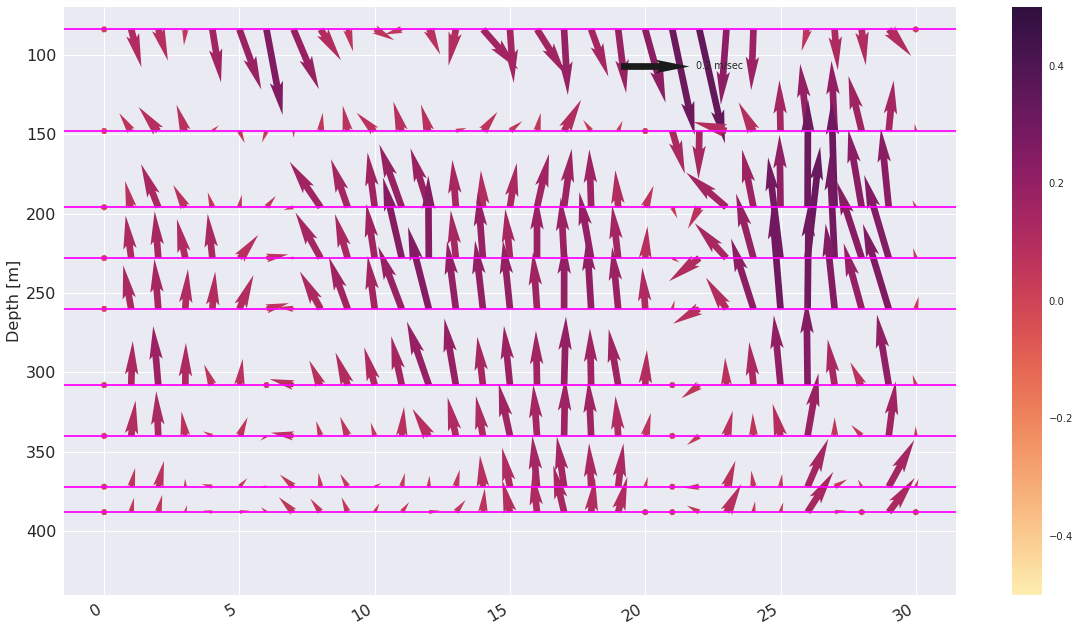

In [20]:
sns.set_style('dark')

step = 1

# time_axis_quiver = np.arange(0,vel_east_30.shape[0],step)

time_axis_quiver_45 = np.arange(0, east_84.shape[0], step)


mydates = pd.date_range(datetime_A1[:5284][0], datetime_A1[:5284][-1], freq="D")

date1 = '2013-04-29'
date2 = '2013-10-25'
mydates_NEP = pd.date_range(date1, date2, freq= 'D')





fig, ax = plt.subplots(1, 1, figsize=(20,12))



Speed_84[Speed_84>2] = 'Nan'

ax.quiver(time_axis_quiver_45, 84, east_84[:], north_84[:], Speed_84[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=84, color='magenta', label = '84 m')

ax.quiver(time_axis_quiver_45, 148, east_148[:], north_148[:], Speed_148[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=148, color='magenta', label = '148 m')

ax.quiver(time_axis_quiver_45, 196, east_196[:], north_196[:], Speed_196[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=196, color='magenta', label = '196 m')


ax.quiver(time_axis_quiver_45, 228, east_228[:], north_228[:], Speed_228[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=228, color='magenta', label = '228 m')

ax.quiver(time_axis_quiver_45, 260, east_260[:], north_260[:], Speed_260[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=260, color='magenta', label = '260 m')

ax.quiver(time_axis_quiver_45, 308, east_308[:], north_308[:], Speed_308[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=308, color='magenta', label = '308 m')

ax.quiver(time_axis_quiver_45, 340, east_340[:], north_340[:], Speed_340[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=340, color='magenta', label = '340 m')

ax.quiver(time_axis_quiver_45, 372, east_372[:], north_372[:], Speed_372[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=372, color='magenta', label = '372 m')

Q = ax.quiver(time_axis_quiver_45, 388, east_388[:], north_388[:], Speed_388[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 2)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=388, color='magenta', label = '388 m')



ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver_45[::2], mydates[1200:1600::2], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d-%h-%m')
fig.autofmt_xdate()
ax.set_ylim(70,440)
ax.invert_yaxis()
ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E') 
ax.tick_params(axis='both',labelsize =16)
plt.colorbar(sm)
ax.grid()

In [44]:
mydates.shape

(30,)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


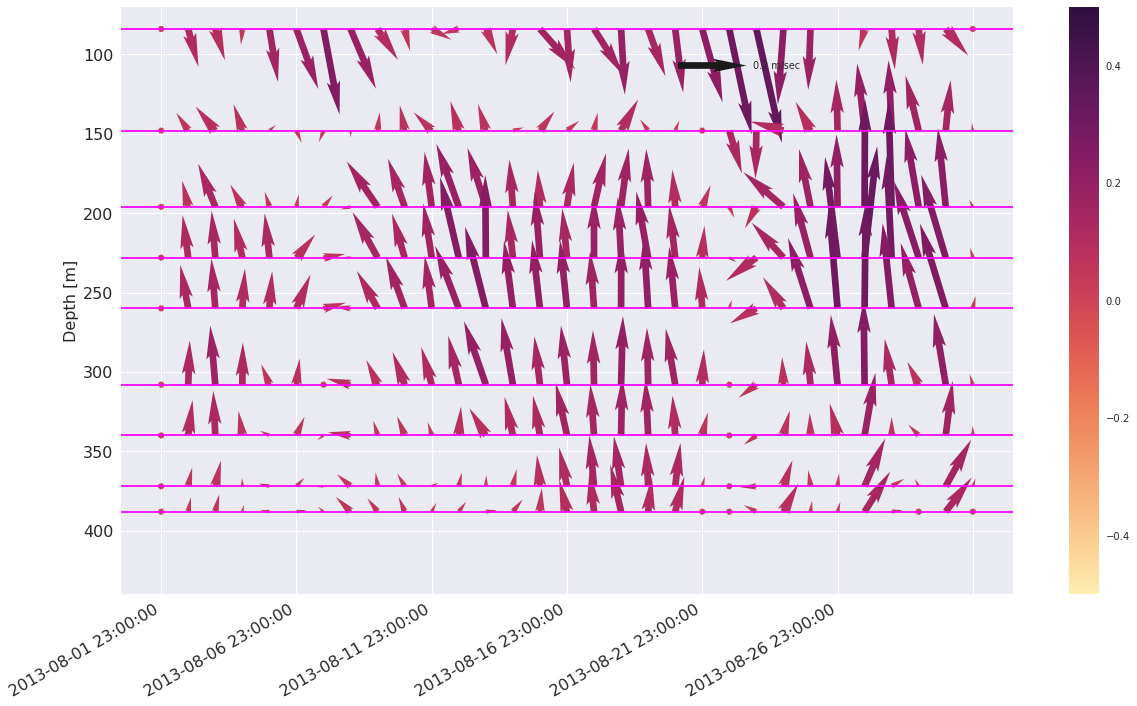

In [47]:
sns.set_style('dark')

step = 1

# time_axis_quiver = np.arange(0,vel_east_30.shape[0],step)

time_axis_quiver_45 = np.arange(0, east_84.shape[0], step)


mydates = pd.date_range(datetime_A1[1200:2600][0], datetime_A1[1200:2600][-1], freq="D")

date1 = '2013-04-29'
date2 = '2013-10-25'
mydates_NEP = pd.date_range(date1, date2, freq= 'D')





fig, ax = plt.subplots(1, 1, figsize=(20,12))



Speed_84[Speed_84>2] = 'Nan'

ax.quiver(time_axis_quiver_45, 84, east_84[:], north_84[:], Speed_84[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=84, color='magenta', label = '84 m')

ax.quiver(time_axis_quiver_45, 148, east_148[:], north_148[:], Speed_148[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=148, color='magenta', label = '148 m')

ax.quiver(time_axis_quiver_45, 196, east_196[:], north_196[:], Speed_196[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=196, color='magenta', label = '196 m')


ax.quiver(time_axis_quiver_45, 228, east_228[:], north_228[:], Speed_228[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=228, color='magenta', label = '228 m')

ax.quiver(time_axis_quiver_45, 260, east_260[:], north_260[:], Speed_260[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=260, color='magenta', label = '260 m')

ax.quiver(time_axis_quiver_45, 308, east_308[:], north_308[:], Speed_308[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=308, color='magenta', label = '308 m')

ax.quiver(time_axis_quiver_45, 340, east_340[:], north_340[:], Speed_340[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=340, color='magenta', label = '340 m')

ax.quiver(time_axis_quiver_45, 372, east_372[:], north_372[:], Speed_372[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=372, color='magenta', label = '372 m')

Q = ax.quiver(time_axis_quiver_45, 388, east_388[:], north_388[:], Speed_388[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 2)#, scale=0.3)# , minshaft = 3)
ax.axhline(y=388, color='magenta', label = '388 m')



ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver_45[::5], mydates[::5], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d-%h-%m')
fig.autofmt_xdate()
ax.set_ylim(70,440)
ax.invert_yaxis()
ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E') 
ax.tick_params(axis='both',labelsize =16)
plt.colorbar(sm)
ax.grid()

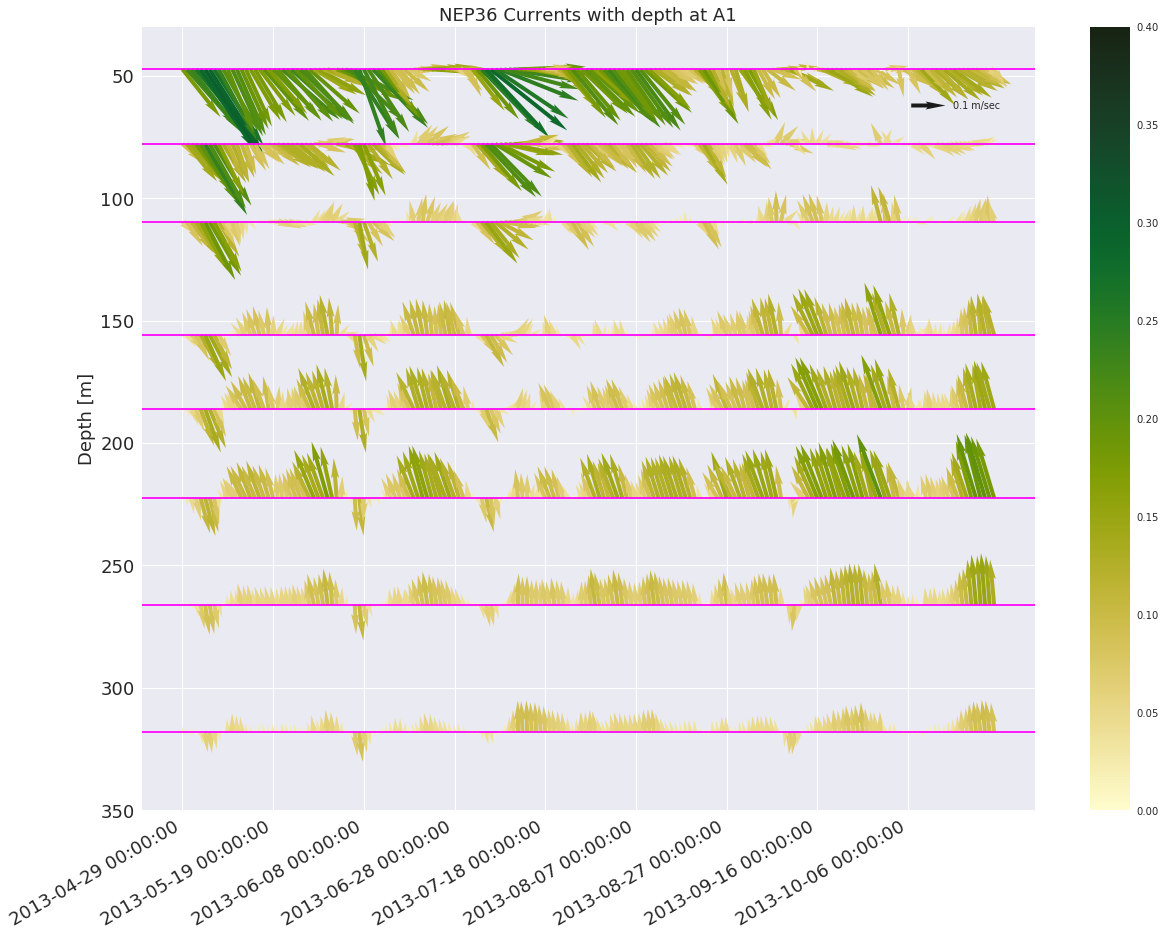

In [54]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[24], u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[25], u_unrotated[:,25,j,i], v_unrotated[:,25,j,i],  mag_vel[:,25,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

Q = ax.quiver(time_axis_quiver, zlevels[26], u_unrotated[:,26,j,i], v_unrotated[:,26,j,i],  mag_vel[:,26,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))

Q = ax.quiver(time_axis_quiver, zlevels[27],u_unrotated[:,27,j,i], v_unrotated[:,27,j,i],  mag_vel[:,27,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[27], color='magenta', label = '{0} m'.format(zlevels[27]))

Q = ax.quiver(time_axis_quiver, zlevels[28],u_unrotated[:,28,j,i], v_unrotated[:,28,j,i],  mag_vel[:,28,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[28], color='magenta', label = '{0} m'.format(zlevels[28]))

# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')


ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(30, 350)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.9, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm_NEP)

In [40]:
np.mean(Speed_196)

0.13224566148736253

In [41]:
np.mean(mag_vel[94:125,25,j,i])

0.07197604842310773

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


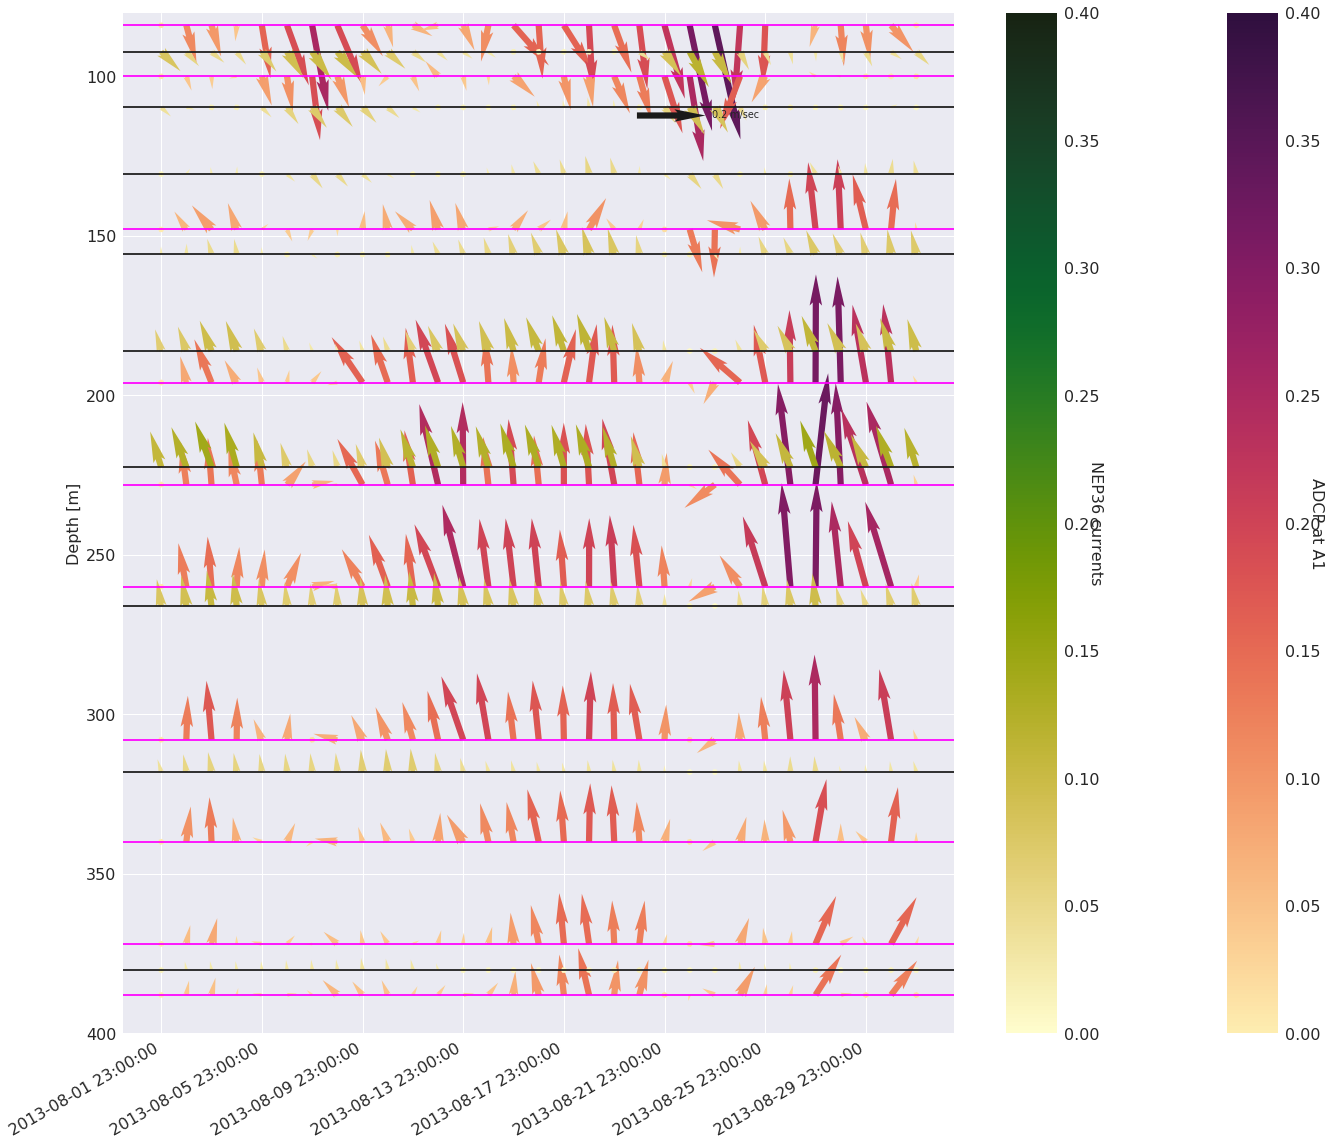

In [55]:
sns.set_style('dark')

step = 1

# time_axis_quiver = np.arange(0,vel_east_30.shape[0],step)

time_axis_quiver_45 = np.arange(0, east_84.shape[0], step)


mydates = pd.date_range(datetime_A1[1200:2600][0], datetime_A1[1200:2600][-1], freq="D")


Speed_100[Speed_100>2] = 'Nan'
Speed_84[Speed_84>2] = 'Nan'



fig, ax = plt.subplots(1, 1, figsize=(20,16))




ax.quiver(time_axis_quiver_45, 84, east_84[:], north_84[:], Speed_84[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=84, color='magenta', label = '84 m')

ax.quiver(time_axis_quiver_45, 100, east_100[:], north_100[:], Speed_100[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=100, color='magenta', label = '100 m')

ax.quiver(time_axis_quiver_45, 148, east_148[:], north_148[:], Speed_148[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=148, color='magenta', label = '148 m')

ax.quiver(time_axis_quiver_45, 196, east_196[:], north_196[:], Speed_196[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=196, color='magenta', label = '196 m')


ax.quiver(time_axis_quiver_45, 228, east_228[:], north_228[:], Speed_228[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=228, color='magenta', label = '228 m')

ax.quiver(time_axis_quiver_45, 260, east_260[:], north_260[:], Speed_260[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=260, color='magenta', label = '260 m')

ax.quiver(time_axis_quiver_45, 308, east_308[:], north_308[:], Speed_308[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=308, color='magenta', label = '308 m')


ax.quiver(time_axis_quiver_45, 340, east_340[:], north_340[:], Speed_340[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=340, color='magenta', label = '340 m')

ax.quiver(time_axis_quiver_45, 372, east_372[:], north_372[:], Speed_372[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=372, color='magenta', label = '372 m')

Q = ax.quiver(time_axis_quiver_45, 388, east_388[:], north_388[:], Speed_388[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=388, color='magenta', label = '388 m')


time_axis_quiver = np.arange(0,31,step)

ax.quiver(time_axis_quiver, zlevels[21],u_unrotated[94:125,21,j,i], v_unrotated[94:125,21,j,i], mag_vel[94:125,21,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[21], color='k', label = '{0} m'.format(zlevels[21]))

ax.quiver(time_axis_quiver, zlevels[22],u_unrotated[94:125,22,j,i], v_unrotated[94:125,22,j,i], mag_vel[94:125,22,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='k', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23],u_unrotated[94:125,23,j,i], v_unrotated[94:125,23,j,i], mag_vel[94:125,23,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[23], color='k', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[24],u_unrotated[94:125,24,j,i], v_unrotated[94:125,24,j,i], mag_vel[94:125,24,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='k', label = '{0} m'.format(zlevels[24]))

ax.quiver(time_axis_quiver, zlevels[25],u_unrotated[94:125,25,j,i], v_unrotated[94:125,25,j,i], mag_vel[94:125,25,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='k', label = '{0} m'.format(zlevels[25]))

ax.quiver(time_axis_quiver, zlevels[26],u_unrotated[94:125,26,j,i], v_unrotated[94:125,26,j,i], mag_vel[94:125,26,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[26], color='k', label = '{0} m'.format(zlevels[26]))

ax.quiver(time_axis_quiver, zlevels[27],u_unrotated[94:125,27,j,i], v_unrotated[94:125,27,j,i], mag_vel[94:125,27,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[27], color='k', label = '{0} m'.format(zlevels[27]))

ax.quiver(time_axis_quiver, zlevels[28],u_unrotated[94:125,28,j,i], v_unrotated[94:125,28,j,i], mag_vel[94:125,28,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[28], color='k', label = '{0} m'.format(zlevels[28]))

Q1= ax.quiver(time_axis_quiver, zlevels[29],u_unrotated[94:125,29,j,i], v_unrotated[94:125,29,j,i], mag_vel[94:125,29,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[29], color='k', label = '{0} m'.format(zlevels[29]))

ax.set_ylabel('Depth [m]', fontsize =16)

plt.xticks(time_axis_quiver_45[::4], mydates[::4], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d-%h-%m')
fig.autofmt_xdate()
ax.set_ylim(80,400)
ax.invert_yaxis()
ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E') 
ax.tick_params(axis='both',labelsize =16)

cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('ADCP at A1', rotation=270, fontsize = 16)

cbar = plt.colorbar(sm_NEP)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('NEP36 currents', rotation=270, fontsize = 16)

# ax.legend((Q, Q1), ('A1 Station Data', 'NEP36'), loc = 'best', fontsize = 12)

fig.tight_layout()
ax.grid()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


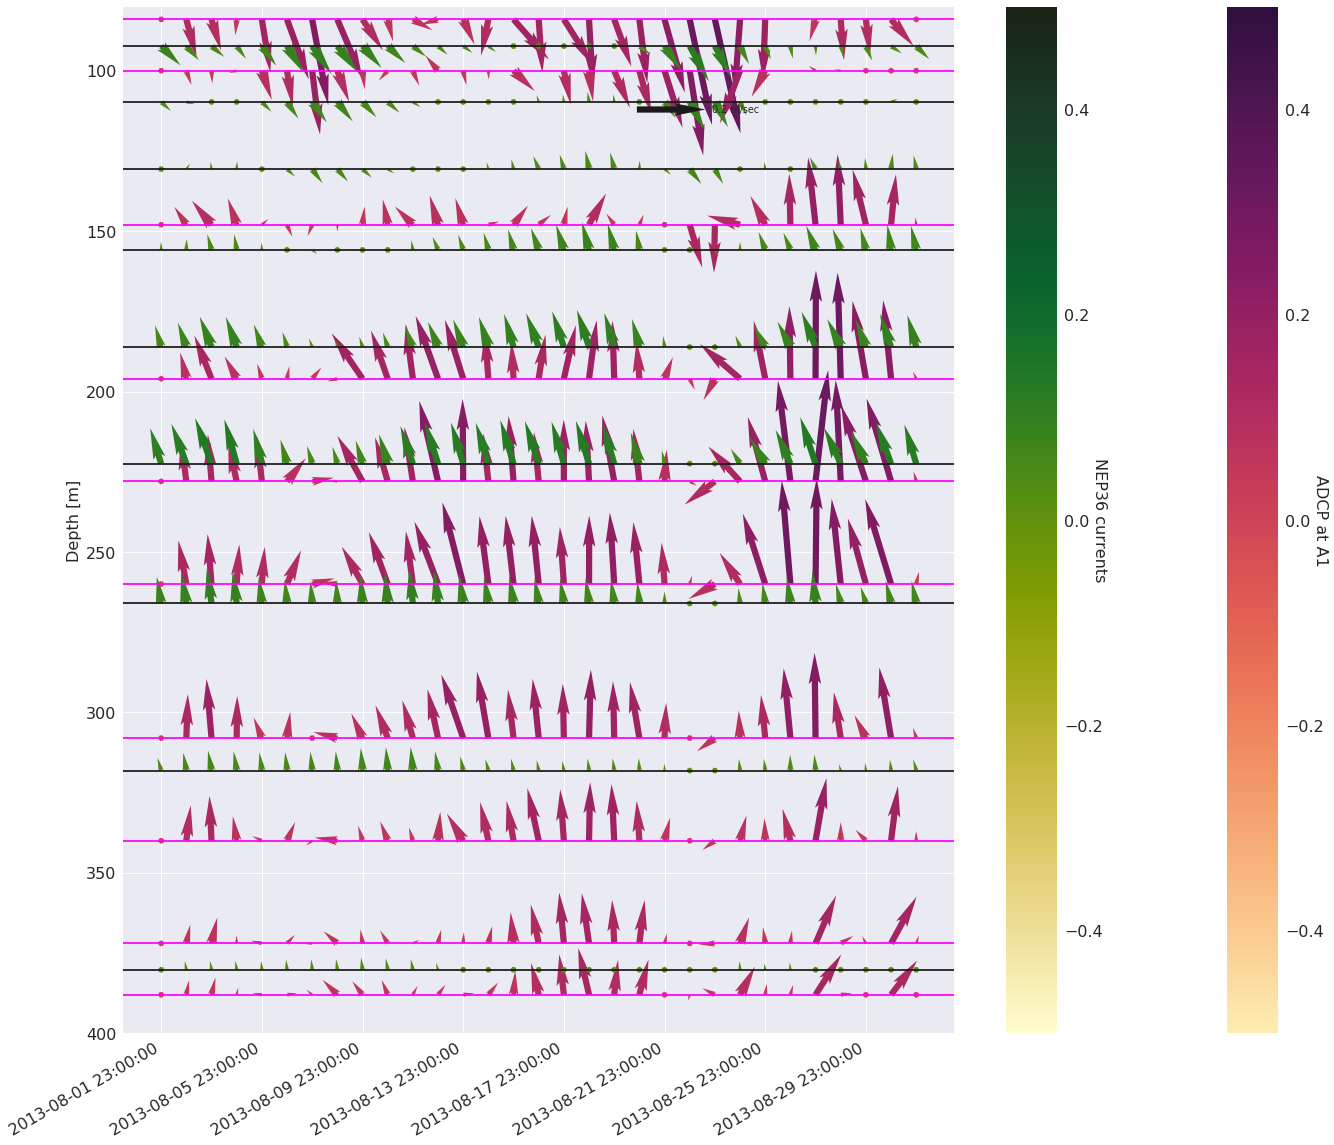

In [67]:
sns.set_style('dark')

step = 1

# time_axis_quiver = np.arange(0,vel_east_30.shape[0],step)

time_axis_quiver_45 = np.arange(0, east_84.shape[0], step)


mydates = pd.date_range(datetime_A1[1200:2600][0], datetime_A1[1200:2600][-1], freq="D")


Speed_100[Speed_100>2] = 'Nan'
Speed_84[Speed_84>2] = 'Nan'



fig, ax = plt.subplots(1, 1, figsize=(20,16))




ax.quiver(time_axis_quiver_45, 84, east_84[:], north_84[:], Speed_84[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=84, color='magenta', label = '84 m')

ax.quiver(time_axis_quiver_45, 100, east_100[:], north_100[:], Speed_100[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=100, color='magenta', label = '100 m')

ax.quiver(time_axis_quiver_45, 148, east_148[:], north_148[:], Speed_148[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=148, color='magenta', label = '148 m')

ax.quiver(time_axis_quiver_45, 196, east_196[:], north_196[:], Speed_196[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=196, color='magenta', label = '196 m')


ax.quiver(time_axis_quiver_45, 228, east_228[:], north_228[:], Speed_228[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=228, color='magenta', label = '228 m')

ax.quiver(time_axis_quiver_45, 260, east_260[:], north_260[:], Speed_260[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=260, color='magenta', label = '260 m')

ax.quiver(time_axis_quiver_45, 308, east_308[:], north_308[:], Speed_308[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=308, color='magenta', label = '308 m')


ax.quiver(time_axis_quiver_45, 340, east_340[:], north_340[:], Speed_340[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=340, color='magenta', label = '340 m')

ax.quiver(time_axis_quiver_45, 372, east_372[:], north_372[:], Speed_372[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=372, color='magenta', label = '372 m')

Q = ax.quiver(time_axis_quiver_45, 388, east_388[:], north_388[:], Speed_388[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=388, color='magenta', label = '388 m')


time_axis_quiver = np.arange(0,31,step)

ax.quiver(time_axis_quiver, zlevels[21],u_unrotated[94:125,21,j,i], v_unrotated[94:125,21,j,i], mag_vel[94:125,21,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[21], color='k', label = '{0} m'.format(zlevels[21]))

ax.quiver(time_axis_quiver, zlevels[22],u_unrotated[94:125,22,j,i], v_unrotated[94:125,22,j,i], mag_vel[94:125,22,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='k', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23],u_unrotated[94:125,23,j,i], v_unrotated[94:125,23,j,i], mag_vel[94:125,23,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[23], color='k', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[24],u_unrotated[94:125,24,j,i], v_unrotated[94:125,24,j,i], mag_vel[94:125,24,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='k', label = '{0} m'.format(zlevels[24]))

ax.quiver(time_axis_quiver, zlevels[25],u_unrotated[94:125,25,j,i], v_unrotated[94:125,25,j,i], mag_vel[94:125,25,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='k', label = '{0} m'.format(zlevels[25]))

ax.quiver(time_axis_quiver, zlevels[26],u_unrotated[94:125,26,j,i], v_unrotated[94:125,26,j,i], mag_vel[94:125,26,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[26], color='k', label = '{0} m'.format(zlevels[26]))

ax.quiver(time_axis_quiver, zlevels[27],u_unrotated[94:125,27,j,i], v_unrotated[94:125,27,j,i], mag_vel[94:125,27,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[27], color='k', label = '{0} m'.format(zlevels[27]))

ax.quiver(time_axis_quiver, zlevels[28],u_unrotated[94:125,28,j,i], v_unrotated[94:125,28,j,i], mag_vel[94:125,28,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[28], color='k', label = '{0} m'.format(zlevels[28]))

Q1= ax.quiver(time_axis_quiver, zlevels[29],u_unrotated[94:125,29,j,i], v_unrotated[94:125,29,j,i], mag_vel[94:125,29,j,i], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)#, scale_units='inches')
ax.axhline(y=zlevels[29], color='k', label = '{0} m'.format(zlevels[29]))

ax.set_ylabel('Depth [m]', fontsize =16)

plt.xticks(time_axis_quiver_45[::4], mydates[::4], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d-%h-%m')
fig.autofmt_xdate()
ax.set_ylim(80,400)
ax.invert_yaxis()
ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E') 
ax.tick_params(axis='both',labelsize =16)

cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('ADCP at A1', rotation=270, fontsize = 16)

cbar = plt.colorbar(sm_NEP)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('NEP36 currents', rotation=270, fontsize = 16)

# ax.legend((Q, Q1), ('A1 Station Data', 'NEP36'), loc = 'best', fontsize = 12)

fig.tight_layout()
ax.grid()

In [58]:
east_84[2]

0.02815690979166666

In [59]:
north_84[2]

-0.091321601375000006

In [17]:
# i = 2

arrays_east = [east_84, east_100, east_148, east_196, east_228, east_260, east_308, east_340, east_372, east_388]
arrays_north = [north_84, north_100, north_148, north_196, north_228, north_260, north_308, north_340, north_372, north_388]
arrays_speed = [Speed_84, Speed_100, Speed_148, Speed_196, Speed_228, Speed_260, Speed_308, Speed_340, Speed_372, Speed_388]

z_ADCP = [84.44, 100.44, 148.44, 196.44, 228.44, 260.44, 308.44, 340.44, 372.44, 388.44]

east_ADCP_A_1_august = np.stack(arrays=arrays_east, axis=1)
north_ADCP_A_1_august = np.stack(arrays=arrays_north, axis=1)
speed_ADCP_A_1_august = np.stack(arrays=arrays_speed, axis=1)

east_NEP_august = u_unrotated[94:125,:,j,i]
north_NEP_august = v_unrotated[94:125,:,j,i]
speed_NEP_august = mag_vel[94:125,:,j,i]

In [21]:
east_NEP_august.shape

(31, 32)

In [87]:
zlevels.shape

(32,)

In [148]:
east_NEP_august.shape

(31, 32)

In [159]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0,vmax=0.4)


cm = plt.get_cmap(cmo.cm.matter)

cm_NEP = plt.get_cmap(cmo.cm.balance)

# cmap.set_bad('Burlywood')

# norm = matplotlib.colors.Normalize()
# norm.autoscale(~np.isnan(mag_84))
# cm = matplotlib.cm.copper

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])



sm_NEP = matplotlib.cm.ScalarMappable(cmap=cm_NEP, norm=norm)
sm_NEP.set_array([])

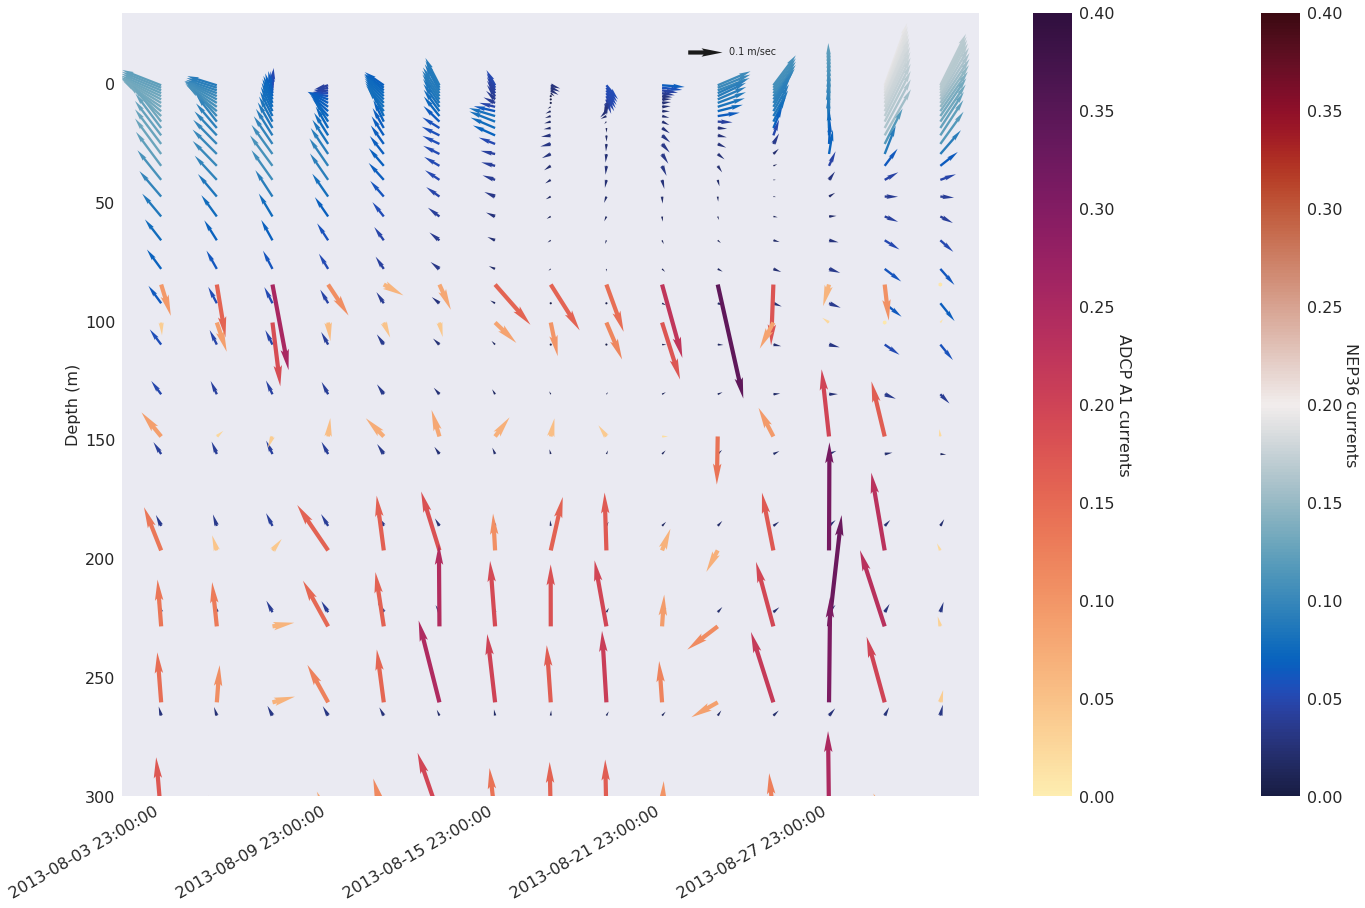

In [168]:
fig2, ax2 = plt.subplots(1,1,figsize=(24,16))

step = 2
time_axis_quiver = np.arange(0,31)
# ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')

Q = ax2.quiver(time_axis_quiver[2::step], zlevels[:], \
           np.transpose(east_NEP_august[2::step,:]), np.transpose(north_NEP_august[2::step,:]),np.transpose(speed_NEP_august[2::step,:]),\
               angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)
Q1 = ax2.quiver(time_axis_quiver[2::step], z_ADCP[:], \
           np.transpose(east_ADCP_A_1_august[2::step,:]), np.transpose(north_ADCP_A_1_august[2::step,:]),np.transpose(speed_ADCP_A_1_august[2::step,:]),\
               angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)

ax2.quiverkey(Q1, 0.7, 0.95, 0.1, r'0.1 m/sec', labelpos='E') 

# ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(-30,300)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
# ax2.xaxis.set_label_position('top') 
# ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
plt.xticks(time_axis_quiver_45[2::6], mydates[2::6], fontsize = 16)
fig2.autofmt_xdate()
# # ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
# ax2.legend(loc= 'best')
# # ax2.set_xlim(-0.0035,0.0035)

cbar = plt.colorbar(sm_NEP)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('NEP36 currents', rotation=270, fontsize = 16, labelpad =16)

cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('ADCP A1 currents', rotation=270, fontsize = 16, labelpad =16)


### Deeper than shelf brek depths the NEP velocitites are smaller than the station velocities, in general but seems to be consistent in direction with adcp data at station A1

In [18]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [19]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    

In [20]:
u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx));

In [21]:
u_unrotated = u_tzyx
v_unrotated = v_tzyx



In [22]:

lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


print(j,i)


89 92


In [15]:
date1 = '2013-04-29'
date2 = '2013-10-25'
mydates = pd.date_range(date1, date2, freq= 'D')

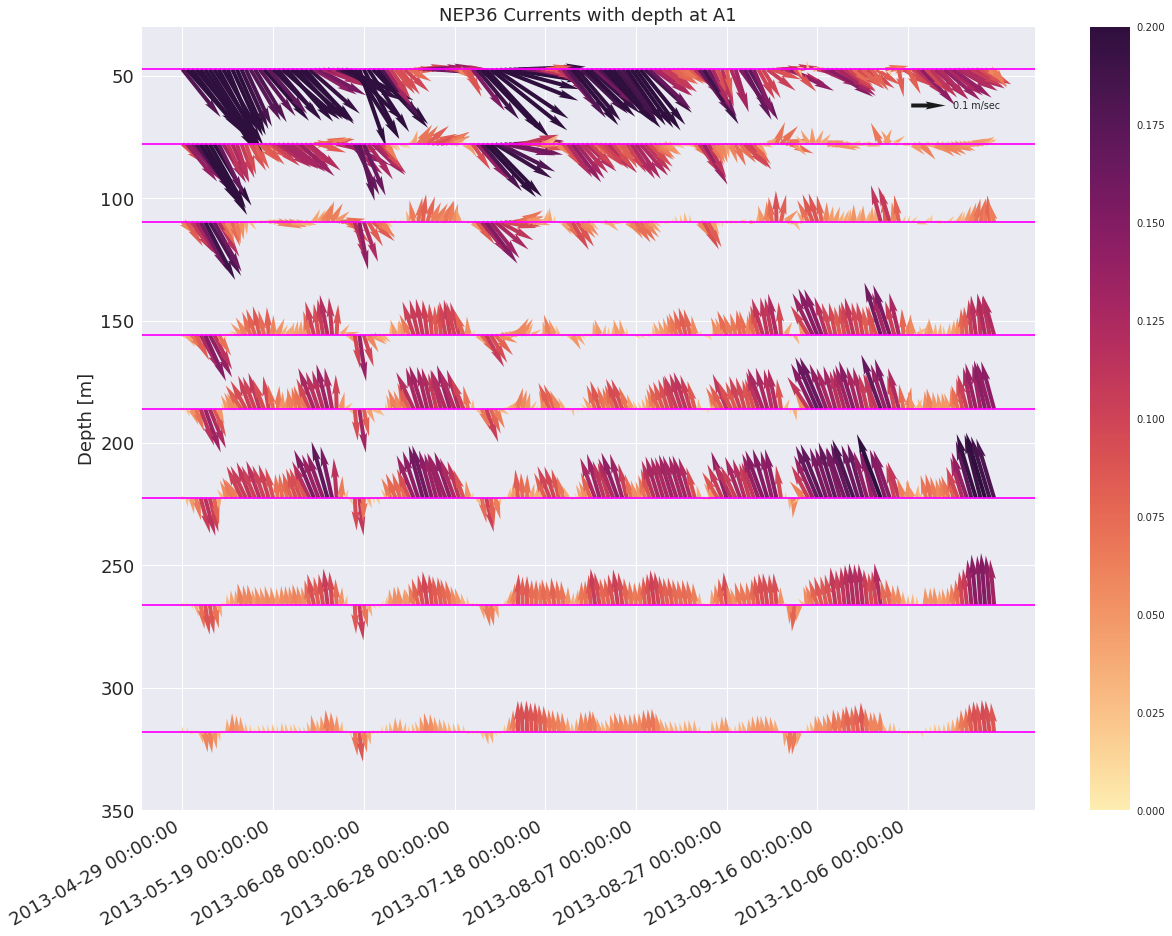

In [121]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[24], u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[25], u_unrotated[:,25,j,i], v_unrotated[:,25,j,i],  mag_vel[:,25,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

Q = ax.quiver(time_axis_quiver, zlevels[26], u_unrotated[:,26,j,i], v_unrotated[:,26,j,i],  mag_vel[:,26,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))

Q = ax.quiver(time_axis_quiver, zlevels[27],u_unrotated[:,27,j,i], v_unrotated[:,27,j,i],  mag_vel[:,27,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[27], color='magenta', label = '{0} m'.format(zlevels[27]))

Q = ax.quiver(time_axis_quiver, zlevels[28],u_unrotated[:,28,j,i], v_unrotated[:,28,j,i],  mag_vel[:,28,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[28], color='magenta', label = '{0} m'.format(zlevels[28]))

# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')


ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(30, 350)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.9, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm)

### NEP36 correctly estimates the dip during the MVP survey \
(the slightly reduced northward flow at depth during those days at the end of August and even southward in the real station data)

In [208]:
lon_JF3 = -125.20267
lat_JF3 = 48.25867

j, i = geo_tools.find_closest_model_point(lon_JF3,lat_JF3,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


print(j,i)

74 130


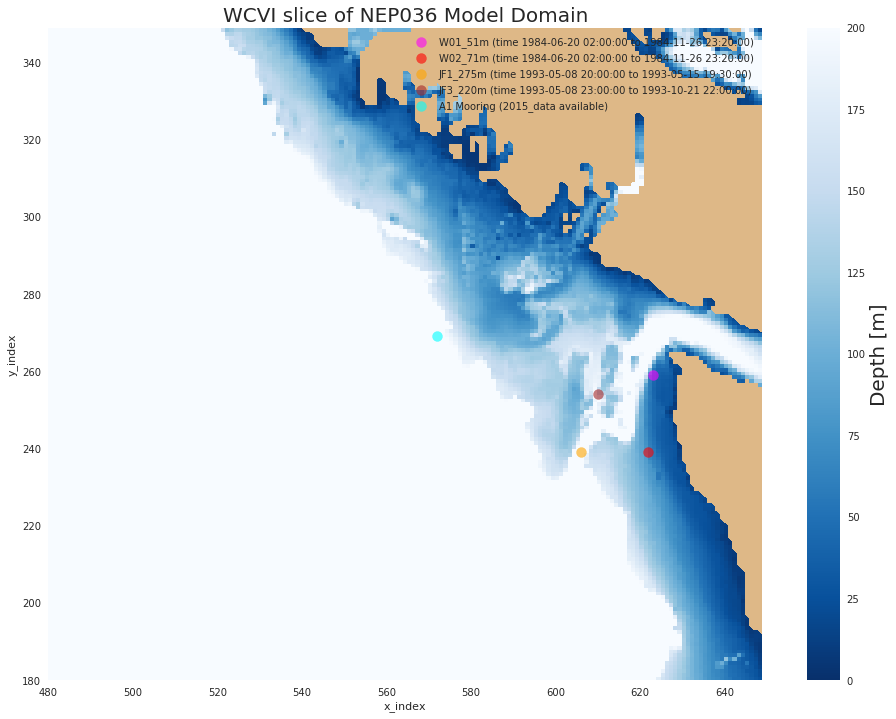

In [200]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']

y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)



lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]


cmap = plt.get_cmap('Blues_r')

cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=200)




lon_W01 = -124.82500
lat_W01 = 48.31500

j, i = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})      
ax.scatter(i, j, c='magenta', s=100, alpha=0.6, label = 'W01_51m (time 1984-06-20 02:00:00 to 1984-11-26 23:20:00)')

lon_W02 = -124.89500
lat_W02 = 48.04167

y, x = geo_tools.find_closest_model_point(lon_W02,lat_W02,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(x, y, c='red', s=100, alpha=0.6, label = 'W02_71m (time 1984-06-20 02:00:00 to 1984-11-26 23:20:00)')

lon_JF1 = -125.31383
lat_JF1 = 48.05433

y, x = geo_tools.find_closest_model_point(lon_JF1,lat_JF1,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(x, y, c='orange', s=100, alpha=0.6, label = 'JF1_275m (time 1993-05-08 20:00:00 to 1993-05-15 19:30:00)')

lon_JF3 = -125.20267
lat_JF3 = 48.25867

y, x = geo_tools.find_closest_model_point(lon_JF3,lat_JF3,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(x, y, c='brown', s=100, alpha=0.6, label = 'JF3_220m (time 1993-05-08 23:00:00 to 1993-10-21 22:00:00)')


lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
ax.scatter(i, j, c='cyan', s=100, alpha=0.6, label = 'A1 Mooring (2015_data available)')

legend = ax.legend(loc='best', fancybox=True, framealpha=0.8)
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
ax.grid()


In [194]:
print(i)

131


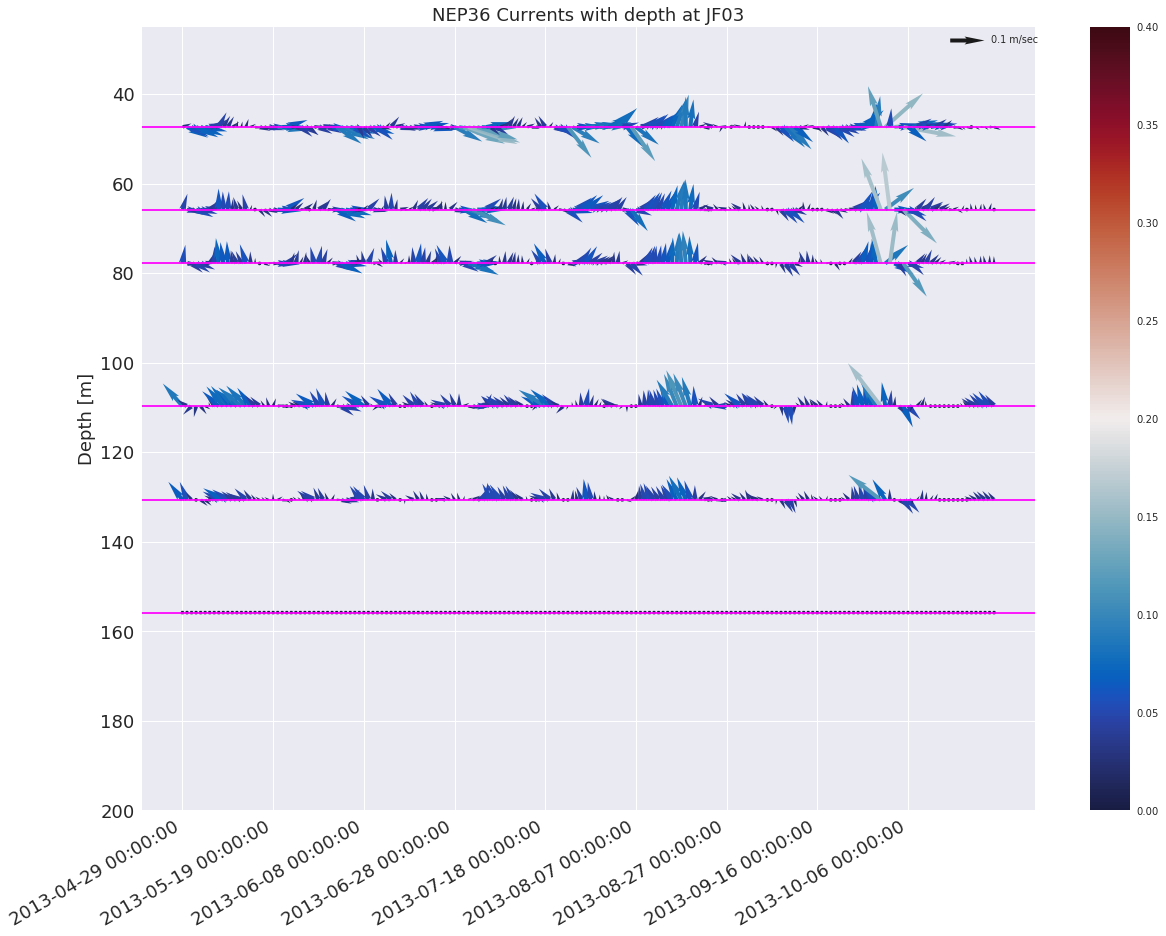

In [209]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[19],u_unrotated[:,19,j,i], v_unrotated[:,19,j,i], mag_vel[:,19,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[19], color='magenta', label = '{0} m'.format(zlevels[19]))


ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23],  u_unrotated[:,23,j,i], v_unrotated[:,23,j,i], mag_vel[:,23,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[24],  u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[24]))

ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(25, 200)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at JF03', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.85, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm_NEP)

In [216]:
j = j-1

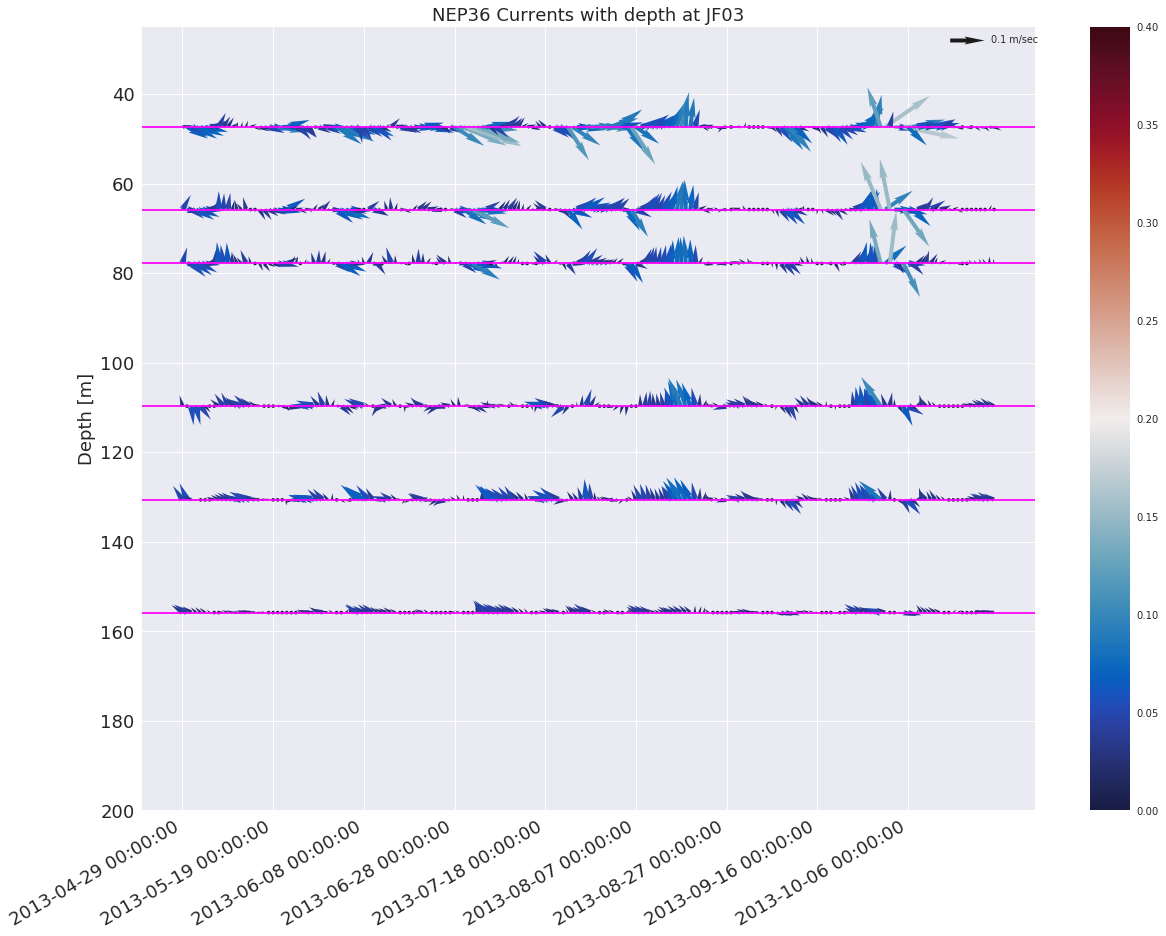

In [217]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[19],u_unrotated[:,19,j,i], v_unrotated[:,19,j,i], mag_vel[:,19,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[19], color='magenta', label = '{0} m'.format(zlevels[19]))


ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23],  u_unrotated[:,23,j,i], v_unrotated[:,23,j,i], mag_vel[:,23,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[24],  u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[24]))

ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(25, 200)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at JF03', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.85, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm_NEP)

In [225]:
j = j-1

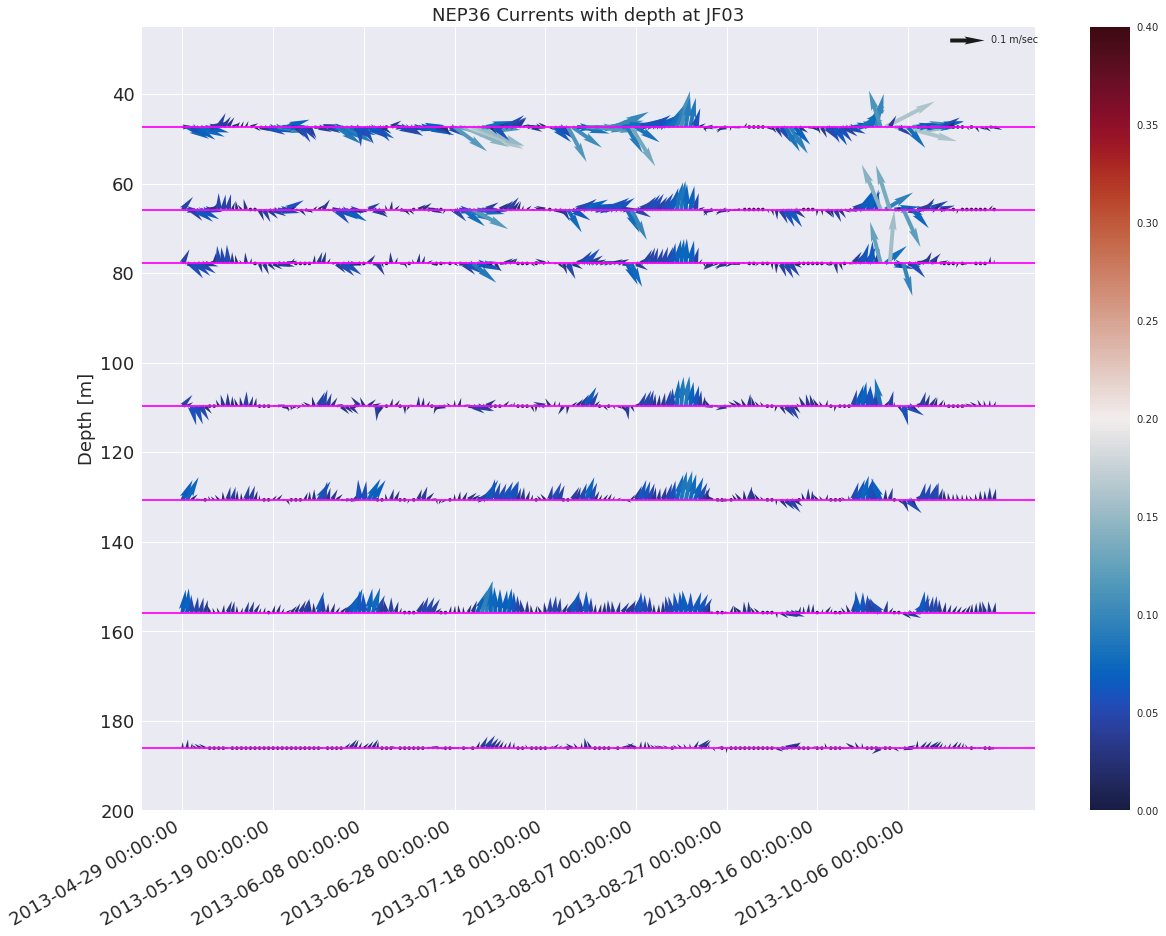

In [227]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[19],u_unrotated[:,19,j,i], v_unrotated[:,19,j,i], mag_vel[:,19,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[19], color='magenta', label = '{0} m'.format(zlevels[19]))


ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23],  u_unrotated[:,23,j,i], v_unrotated[:,23,j,i], mag_vel[:,23,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[24],  u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[24]))

ax.quiver(time_axis_quiver, zlevels[25],  u_unrotated[:,25,j,i], v_unrotated[:,25,j,i], mag_vel[:,25,j,i], angles='uv',cmap = cm_NEP, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[24]))

ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(25, 200)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at JF03', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.85, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm_NEP)

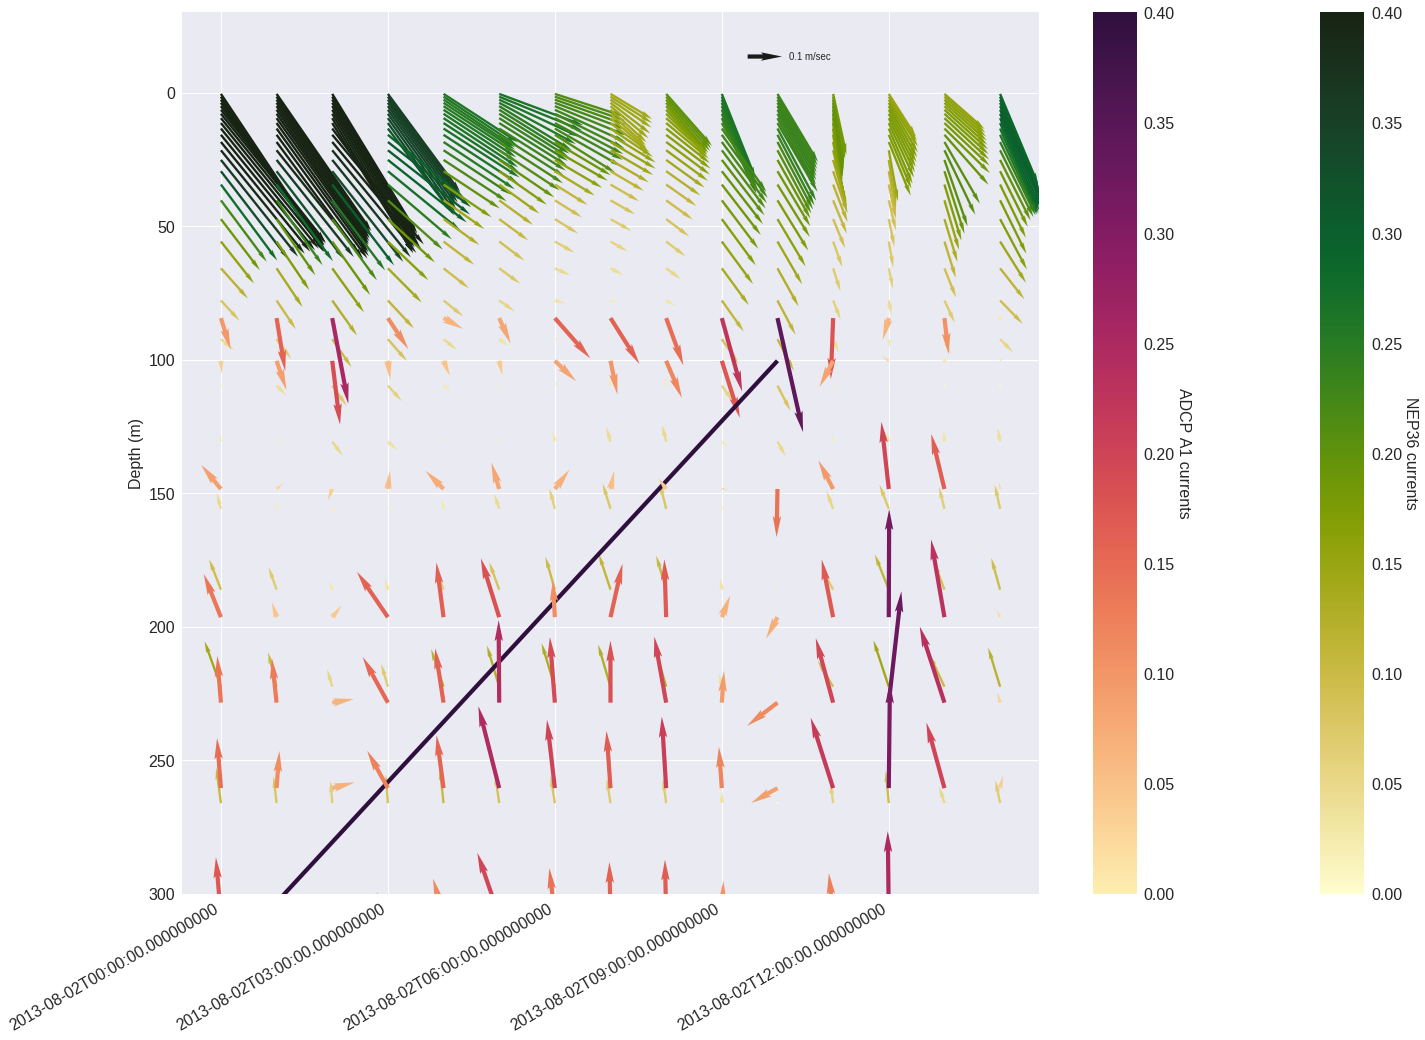

In [27]:
fig2, ax2 = plt.subplots(1,1,figsize=(24,18))

step = 2
time_axis_quiver = np.arange(0,31)
# ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')

Q = ax2.quiver(time_axis_quiver[2::step], zlevels[:], \
           np.transpose(east_NEP_august[2::step,:]), np.transpose(north_NEP_august[2::step,:]),np.transpose(speed_NEP_august[2::step,:]),\
               angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm_NEP, norm = norm)
Q1 = ax2.quiver(time_axis_quiver[2::step], z_ADCP[:], \
           np.transpose(east_ADCP_A_1_august[2::step,:]), np.transpose(north_ADCP_A_1_august[2::step,:]),np.transpose(speed_ADCP_A_1_august[2::step,:]),\
               angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)

ax2.quiverkey(Q1, 0.7, 0.95, 0.1, r'0.1 m/sec', labelpos='E') 

# ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(-30,300)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
# ax2.xaxis.set_label_position('top') 
# ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
plt.xticks(time_axis_quiver[2::6], mydates[2::6], fontsize = 16)
fig2.autofmt_xdate()
# # ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
# ax2.legend(loc= 'best')
# # ax2.set_xlim(-0.0035,0.0035)

cbar = plt.colorbar(sm_NEP)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('NEP36 currents', rotation=270, fontsize = 16, labelpad =16)

cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('ADCP A1 currents', rotation=270, fontsize = 16, labelpad =16)


 A1 currents at August 2 2013


(-0.4, 0.4)

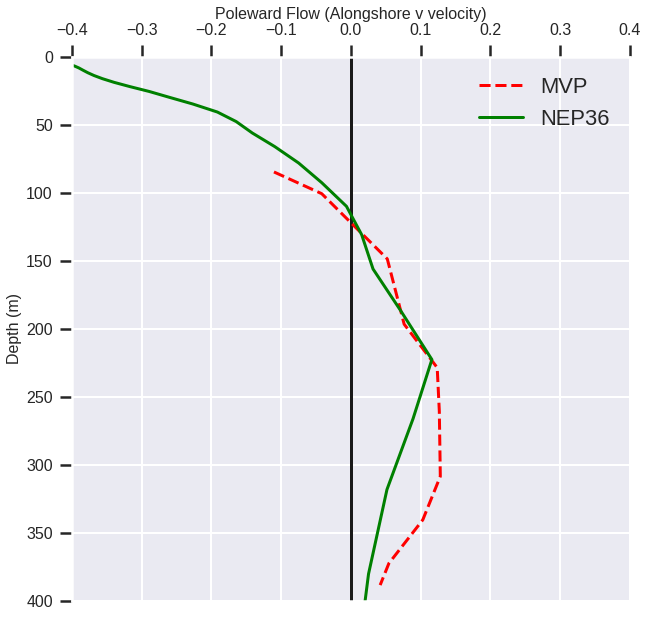

In [47]:
t = 1


print(" A1 currents at August 2 2013")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:],'--',  c = 'red',  label = 'MVP')
  
ax2.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.4,0.4)

In [36]:
p[0]

'c'

 A1 currents at August 2 2013


(-0.4, 0.4)

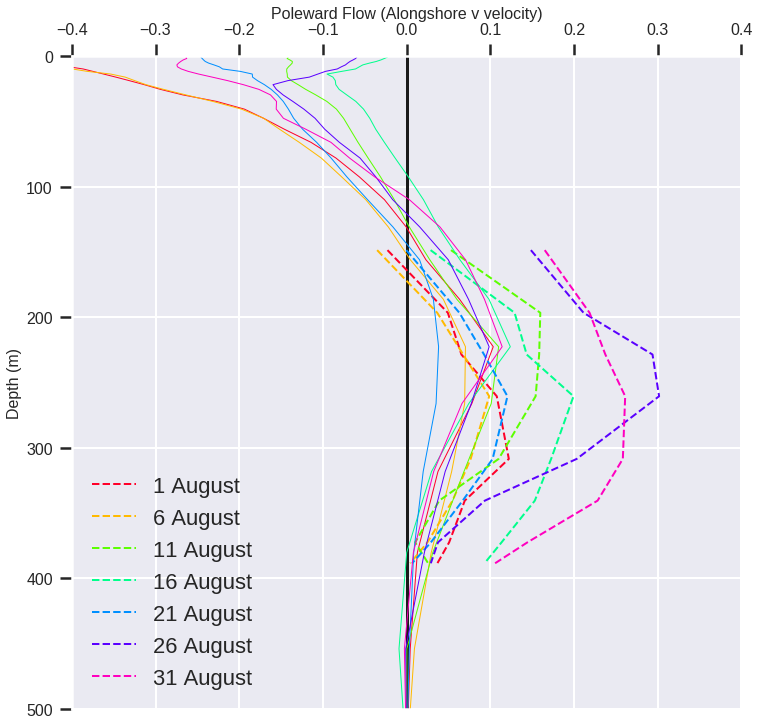

In [41]:


step = 5


print(" A1 currents at August 2 2013")


fig2, ax2 = plt.subplots(1,1,figsize=(12,12))

p = ['c', 'm', 'y', 'k', 'r', 'b', 'g']

r = ['c', 'm', 'y', 'k', 'r', 'b', 'g']

colors = cm.gist_rainbow(np.linspace(0, 1, 31))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape

for t in np.arange(0,31,step):

    ax2.plot(north_ADCP_A_1_august[t,2:] , z_ADCP[2:], '--', c = colors[t], linewidth = 2,  label = '{} August'.format(t+1))

    ax2.plot(north_NEP_august[t,:] , zlevels[:], c = colors[t], linewidth = 1)#, label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,500)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.4,0.4)

 A1 currents at August 2 2013


(-0.4, 0.4)

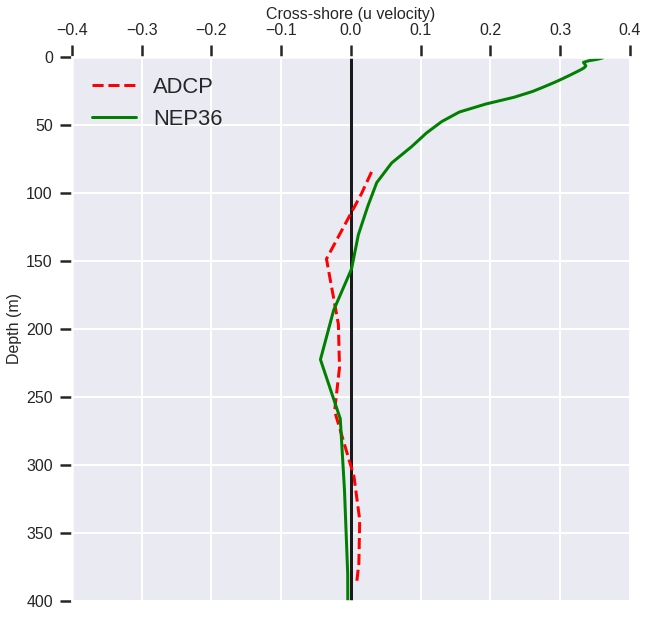

In [43]:
t = 1

print(" A1 currents at August 2 2013")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:], '--',  c = 'red',  label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.4,0.4)

 A1 currents at August 2 2013


(-0.4, 0.4)

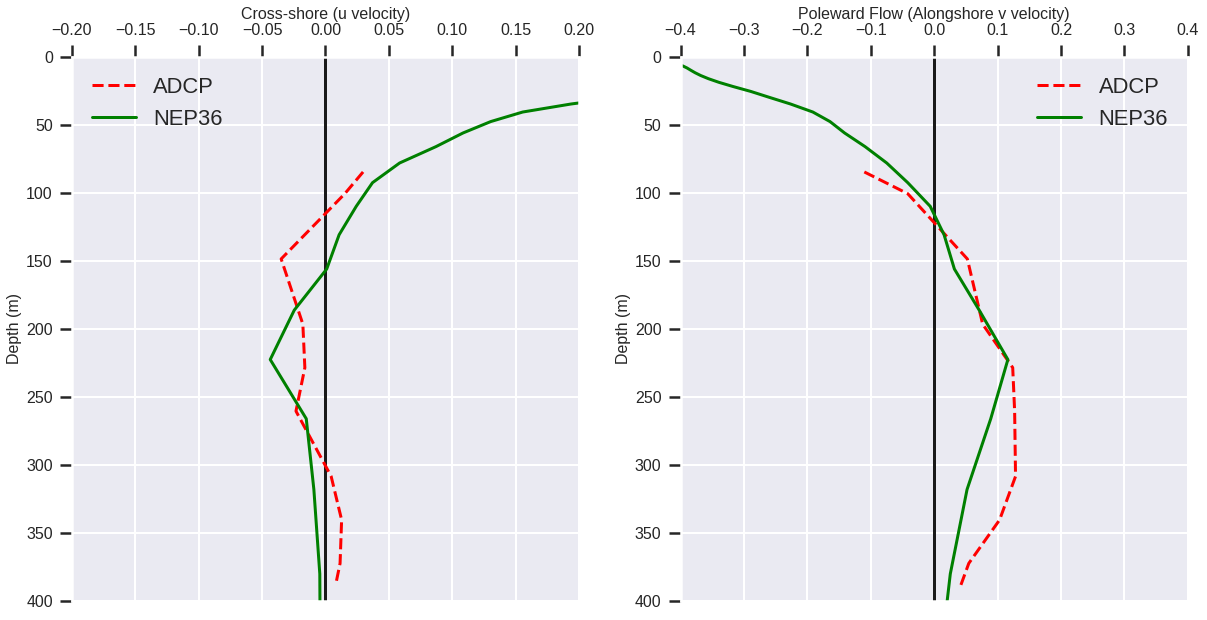

In [46]:
t = 1

print(" A1 currents at August 2 2013")


fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red', label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',   label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax3.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax3.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

 A1 currents at August 8 2013


(-0.4, 0.4)

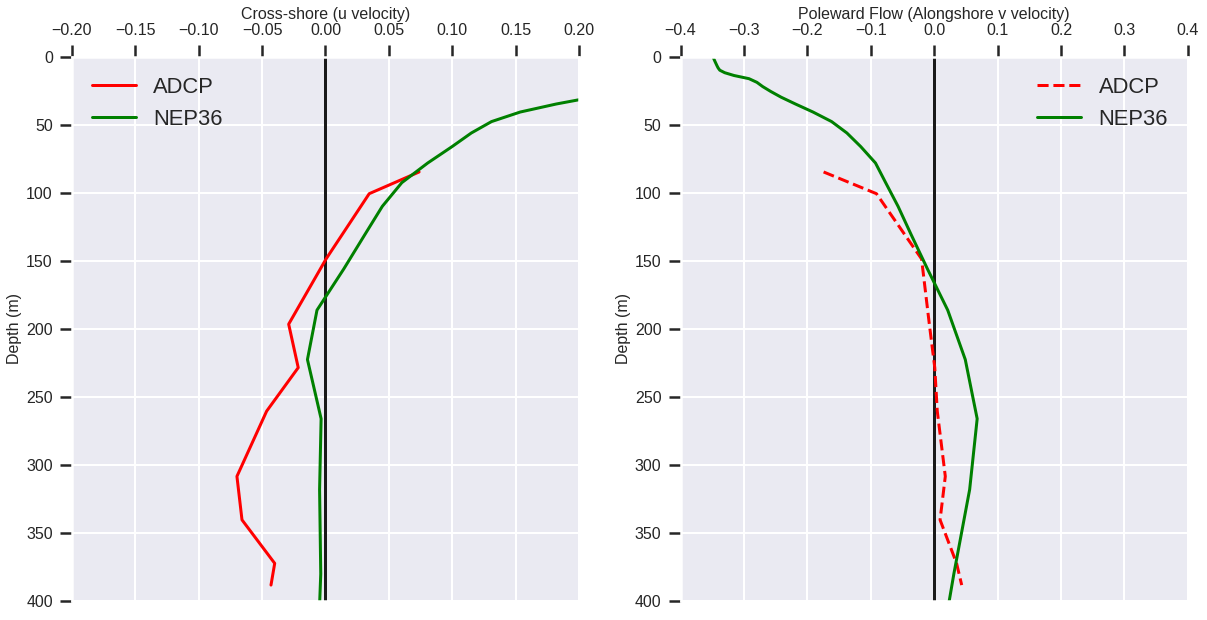

In [48]:
t = 7

print(" A1 currents at August 8 2013")


fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:],  c = 'red',  label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax3.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

 A1 currents at August 15 2013


(-0.4, 0.4)

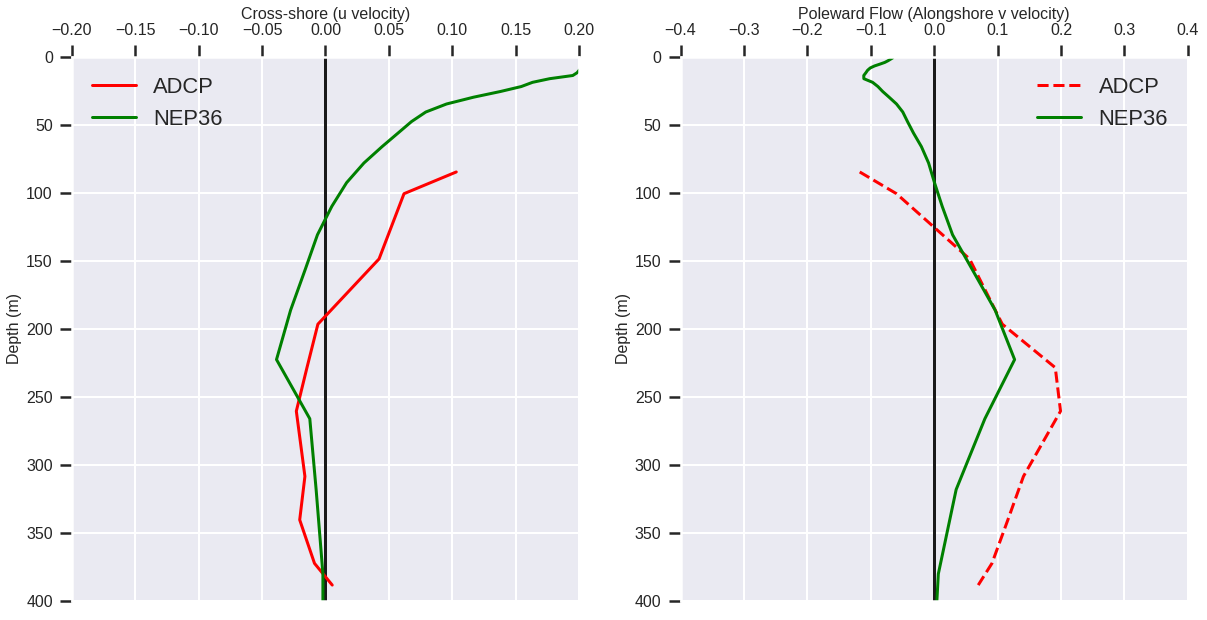

In [49]:
t = 14

print(" A1 currents at August 15 2013")


fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:],  c = 'red',  label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--',  c = 'red',  label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax3.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

 A1 currents at August 20 2013


(-0.4, 0.4)

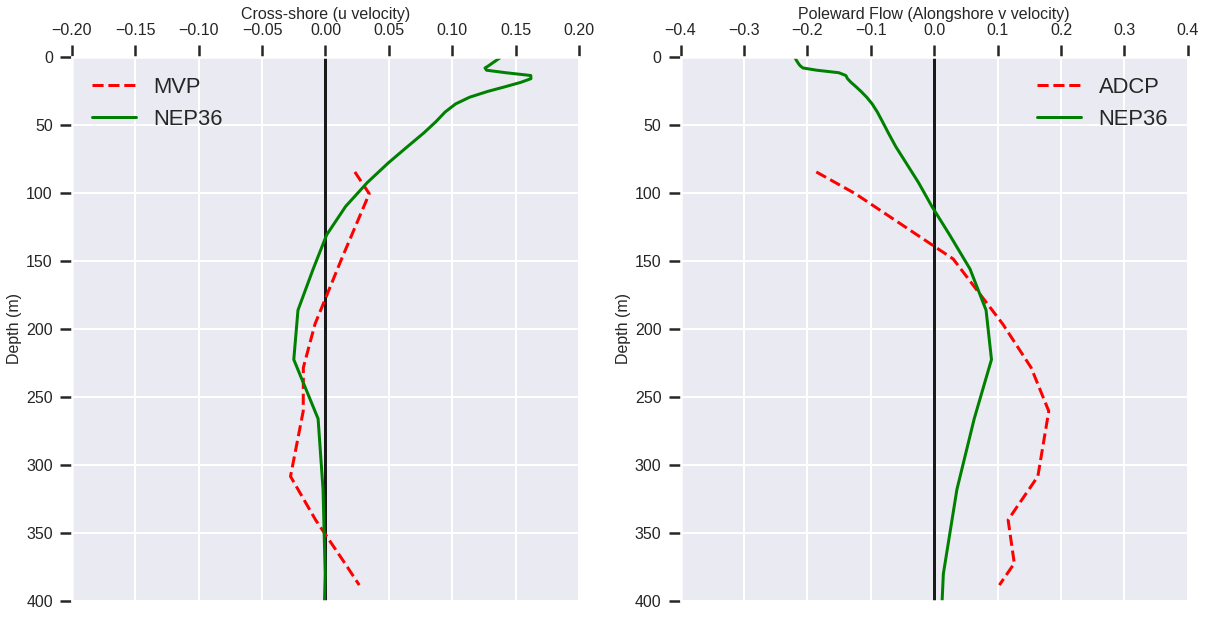

In [50]:
t = 19

print(" A1 currents at August 20 2013")


fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'MVP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax3.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

 A1 currents at August 25 2013


(-0.4, 0.4)

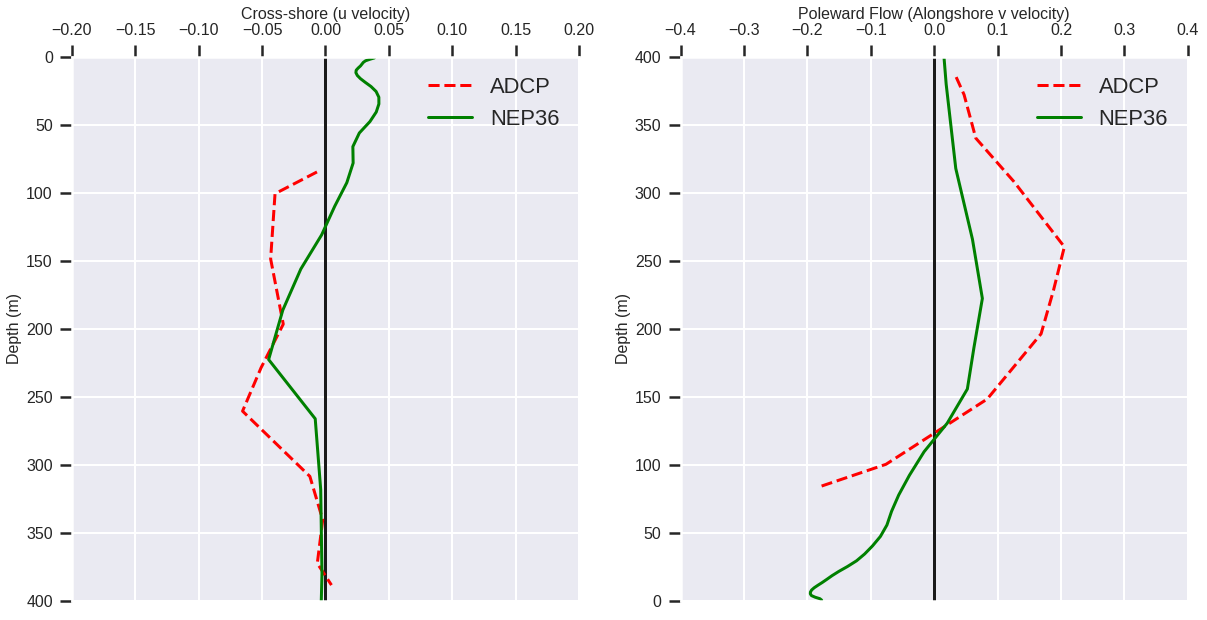

In [51]:
t = 24

print(" A1 currents at August 25 2013")

fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax2.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

 A1 currents at August 31 2013


(-0.4, 0.4)

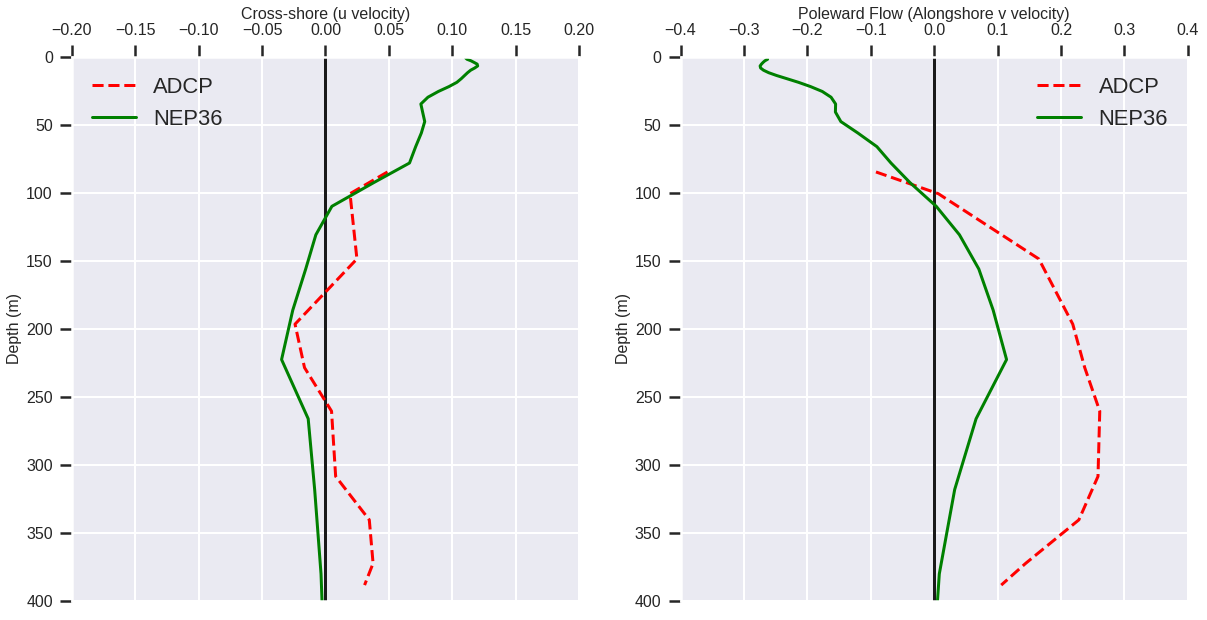

In [53]:
t = 30

print(" A1 currents at August 31 2013")

fig2, (ax2, ax3) = plt.subplots(1,2,figsize=(20,10))

# zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(east_ADCP_A_1_august[t,:] , z_ADCP[:],  '--',c = 'red',  label = 'ADCP')
  
ax2.plot(east_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,400)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Cross-shore (u velocity)', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.2,0.2)



ax3.plot(north_ADCP_A_1_august[t,:] , z_ADCP[:], '--', c = 'red',  label = 'ADCP')
  
ax3.plot(north_NEP_august[t,:] , zlevels[:], c = 'green', label = 'NEP36')

ax3.set_ylabel('Depth (m)', fontsize = 16)
ax3.set_ylim(0,400)
ax3.set_ylim(ax3.get_ylim()[::-1]) 
ax3.set_xlabel('Poleward Flow (Alongshore v velocity)', fontsize = 16)
ax3.xaxis.set_label_position('top') 
ax3.xaxis.set_ticks_position('top') 
ax3.tick_params(axis='both',labelsize =16)
ax3.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax3.legend(loc= 'best')
ax3.set_xlim(-0.4,0.4)

### Let us choose three depths (150m, 200m and 250m) and come up with the statistical skill score to compare the model vs observation data

In [61]:
north_ADCP_A_1_august.shape

(31, 10)

In [4]:
def add_alongshore_data_to_depth_level(depth, v_vel_adcp, v_vel_model, model_depth_levels, obs_depth_levels):
    
    adcp_depth = np.empty((v_vel_adcp.shape[0]))
    model_depth = np.empty((v_vel_model.shape[0]))
    
    for t in np.arange(adcp_depth.shape[0]):
        
        adcp_v = v_vel_adcp[t,:]    
        model_v = v_vel_model[t,:]
    

        z_obs = np.array(obs_depth_levels)
        z_model = np.array(model_depth_levels)
        
    
        func_vel_obs = interp1d(z_obs, adcp_v, fill_value='extrapolate')
        obs_vvel_interp = func_vel_obs(z_obs)
    
        
        func_vel_model = interp1d(z_model, model_v, fill_value='extrapolate')
        model_vvel_interp = func_vel_obs(z_model)
        
        adcp_depth[t] = func_vel_obs(depth)
        model_depth[t] = func_vel_model(depth)
        
    return adcp_depth, model_depth


def get_stat_tem(obs_data, model_data):


    obar = np.nanmean(obs_data)
    mprime = model_data - obar
    oprime = obs_data - obar

    diff_sq = np.sum((model_data-obs_data)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_data - obs_data
    gamma2 = np.var(error)/np.var(obs_data)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws
        



In [42]:
adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=150, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

## Only for the month of August

In [54]:
t1 = 1154
t2 = 2642

In [59]:
print(A1_data['Date'].iloc[t1])

2013/08/01


In [61]:
print(A1_data['Time'].iloc[t1])

00:00:00


In [62]:
print(A1_data['Date'].iloc[t2])

2013/09/01


In [65]:
print(A1_data['Time'].iloc[t2])

00:00:00


In [31]:
t1 = np.where((A1_data['Date'] == '2013/08/01') & (A1_data['Time'] == '00:00:00'))

t2 = np.where((A1_data['Date'] == '2013/09/01') & (A1_data['Time'] == '00:00:00'))


t1 = np.mean(t1)
t1.astype(int)

t2 = np.mean(t2)
t2.astype(int)

print(t1,t2)

1154.0 2642.0


In [6]:
t1 = np.where((A1_data['Date'] == '2013/08/01') & (A1_data['Time'] == '00:00:00'))

t2 = np.where((A1_data['Date'] == '2013/10/01') & (A1_data['Time'] == '00:00:00'))


t1 = np.mean(t1)
t1.astype(int)

t2 = np.mean(t2)
t2.astype(int)

print(t1,t2)



1154.0 4082.0


In [11]:
t1 = np.where((A1_data['Date'] == '2013/07/07') & (A1_data['Time'] == '23:00:00'))

t2 = np.where((A1_data['Date'] == '2013/10/01') & (A1_data['Time'] == '00:00:00'))


t1 = np.mean(t1)
t1.astype(int)

t2 = np.mean(t2)
t2.astype(int)

print(t1,t2)



0.0 4082.0


In [32]:
t1 = 1154
t2 = 2642

In [12]:
t1 = 0
t2 = 4082

In [84]:
t1 = 1154
t2 = 4082

In [33]:
vel_north_84 = np.array(A1_data['vel_north_84.44'], dtype = np.float)[t1:t2]
vel_east_84  = np.array(A1_data['vel_east_84.44'], dtype = np.float)[t1:t2]
mag_84       = np.sqrt(vel_east_84**2+vel_north_84**2)
mag_84[mag_84 > 2] = 'Nan'

vel_north_100= np.array(A1_data['vel_north_100.44'], dtype = np.float)[t1:t2]
vel_east_100 = np.array(A1_data['vel_east_100.44'], dtype = np.float)[t1:t2]
mag_100       = np.sqrt(vel_east_100**2+vel_north_100**2)
mag_100[mag_100 > 2] = 'Nan'

vel_north_116 = np.array(A1_data['vel_north_116.44'], dtype = np.float)[t1:t2]
vel_east_116  = np.array(A1_data['vel_east_116.44'], dtype = np.float)[t1:t2]
mag_116       = np.sqrt(vel_east_116**2+vel_north_116**2)
mag_116[mag_116 > 2] = 'Nan'

vel_north_148 = np.array(A1_data['vel_north_148.44'], dtype = np.float)[t1:t2]
vel_east_148  = np.array(A1_data['vel_east_148.44'], dtype = np.float)[t1:t2]
mag_148       = np.sqrt(vel_east_148**2+vel_north_148**2)

vel_north_164= np.array(A1_data['vel_north_164.44'], dtype = np.float)[t1:t2]
vel_east_164 = np.array(A1_data['vel_east_164.44'], dtype = np.float)[t1:t2]
mag_164       = np.sqrt(vel_east_164**2+vel_north_164**2)
mag_164[mag_164 > 2] = 'Nan'

vel_north_180= np.array(A1_data['vel_north_180.44'], dtype = np.float)[t1:t2]
vel_east_180 = np.array(A1_data['vel_east_180.44'], dtype = np.float)[t1:t2]
mag_180       = np.sqrt(vel_east_180**2+vel_north_180**2)
mag_180[mag_180 > 2] = 'Nan'

vel_north_196 = np.array(A1_data['vel_north_196.44'], dtype = np.float)[t1:t2]
vel_east_196  = np.array(A1_data['vel_east_196.44'], dtype = np.float)[t1:t2]
mag_196      = np.sqrt(vel_east_196**2+vel_north_196**2)

vel_north_228 = np.array(A1_data['vel_north_228.44'], dtype = np.float)[t1:t2]
vel_east_228 = np.array(A1_data['vel_east_228.44'], dtype = np.float)[t1:t2]
mag_228      = np.sqrt(vel_east_228**2+vel_north_228**2)

vel_north_260 = np.array(A1_data['vel_north_260.44'], dtype = np.float)[t1:t2]
vel_east_260 = np.array(A1_data['vel_east_260.44'], dtype = np.float)[t1:t2]
mag_260      = np.sqrt(vel_east_260**2+vel_north_260**2)

vel_north_276 = np.array(A1_data['vel_north_276.44'], dtype = np.float)[t1:t2]
vel_east_276 = np.array(A1_data['vel_east_276.44'], dtype = np.float)[t1:t2]
mag_276      = np.sqrt(vel_east_276**2+vel_north_276**2)

vel_north_292 = np.array(A1_data['vel_north_292.44'], dtype = np.float)[t1:t2]
vel_east_292 = np.array(A1_data['vel_east_292.44'], dtype = np.float)[t1:t2]
mag_292      = np.sqrt(vel_east_292**2+vel_north_292**2)

vel_north_308 = np.array(A1_data['vel_north_308.44'], dtype = np.float)[t1:t2]
vel_east_308 = np.array(A1_data['vel_east_308.44'], dtype = np.float)[t1:t2]
mag_308      = np.sqrt(vel_east_308**2+vel_north_308**2)

vel_north_340 = np.array(A1_data['vel_north_340.44'], dtype = np.float)[t1:t2]
vel_east_340 = np.array(A1_data['vel_east_340.44'], dtype = np.float)[t1:t2]
mag_340      = np.sqrt(vel_east_340**2+vel_north_340**2)

vel_north_372 = np.array(A1_data['vel_north_372.44'], dtype = np.float)[t1:t2]
vel_east_372 = np.array(A1_data['vel_east_372.44'], dtype = np.float)[t1:t2]
mag_372      = np.sqrt(vel_east_372**2+vel_north_372**2)

vel_north_388 = np.array(A1_data['vel_north_388.44'], dtype = np.float)[t1:t2]
vel_east_388 = np.array(A1_data['vel_east_388.44'], dtype = np.float)[t1:t2]
mag_388      = np.sqrt(vel_east_388**2+vel_north_388**2)

In [34]:
mydates = np.array(pd.date_range(datetime_A1[t1:t2][0], datetime_A1[t1:t2][-1], freq="30min"))

A1_series_east = pd.Series(vel_east_84, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)

A1_series_east = pd.Series(vel_east_100, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_100_daily_east = daily_east.values
east_100 = np.divide(vel_100_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_100, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_100_daily_north = daily_north.values
north_100 = np.divide(vel_100_daily_north[:], 24)


Speed_100 = np.sqrt(east_100**2 + north_100**2)


A1_series_east = pd.Series(vel_east_148, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)


A1_series_east = pd.Series(vel_east_340, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_388, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)


A1_series_east = pd.Series(vel_east_372, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_372_daily_east = daily_east.values
east_372 = np.divide(vel_372_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_372, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_372_daily_north = daily_north.values
north_372 = np.divide(vel_372_daily_north[:], 24)


Speed_372 = np.sqrt(east_372**2 + north_372**2)


A1_series_east = pd.Series(vel_east_308, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_308_daily_east = daily_east.values
east_308 = np.divide(vel_308_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_308, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_308_daily_north = daily_north.values
north_308 = np.divide(vel_308_daily_north[:], 24)

Speed_308 = np.sqrt(east_308**2 + north_308**2)



In [35]:
# i = 2

arrays_east = [east_84, east_100, east_148, east_196, east_228, east_260, east_308, east_340, east_372, east_388]
arrays_north = [north_84, north_100, north_148, north_196, north_228, north_260, north_308, north_340, north_372, north_388]
arrays_speed = [Speed_84, Speed_100, Speed_148, Speed_196, Speed_228, Speed_260, Speed_308, Speed_340, Speed_372, Speed_388]

z_ADCP = [84.44, 100.44, 148.44, 196.44, 228.44, 260.44, 308.44, 340.44, 372.44, 388.44]

east_ADCP_A_1_august = np.stack(arrays=arrays_east, axis=1)
north_ADCP_A_1_august = np.stack(arrays=arrays_north, axis=1)
speed_ADCP_A_1_august = np.stack(arrays=arrays_speed, axis=1)

In [37]:
east_NEP_august = u_unrotated[94:125,:,j,i]
north_NEP_august = v_unrotated[94:125,:,j,i]
speed_NEP_august = mag_vel[94:125,:,j,i]

In [27]:
east_NEP_august = u_unrotated[94-25:125+30,:,j,i]
north_NEP_august = v_unrotated[94-25:125+30,:,j,i]
speed_NEP_august = mag_vel[94-25:125+30,:,j,i]

In [26]:
east_NEP_august.shape

(86, 32)

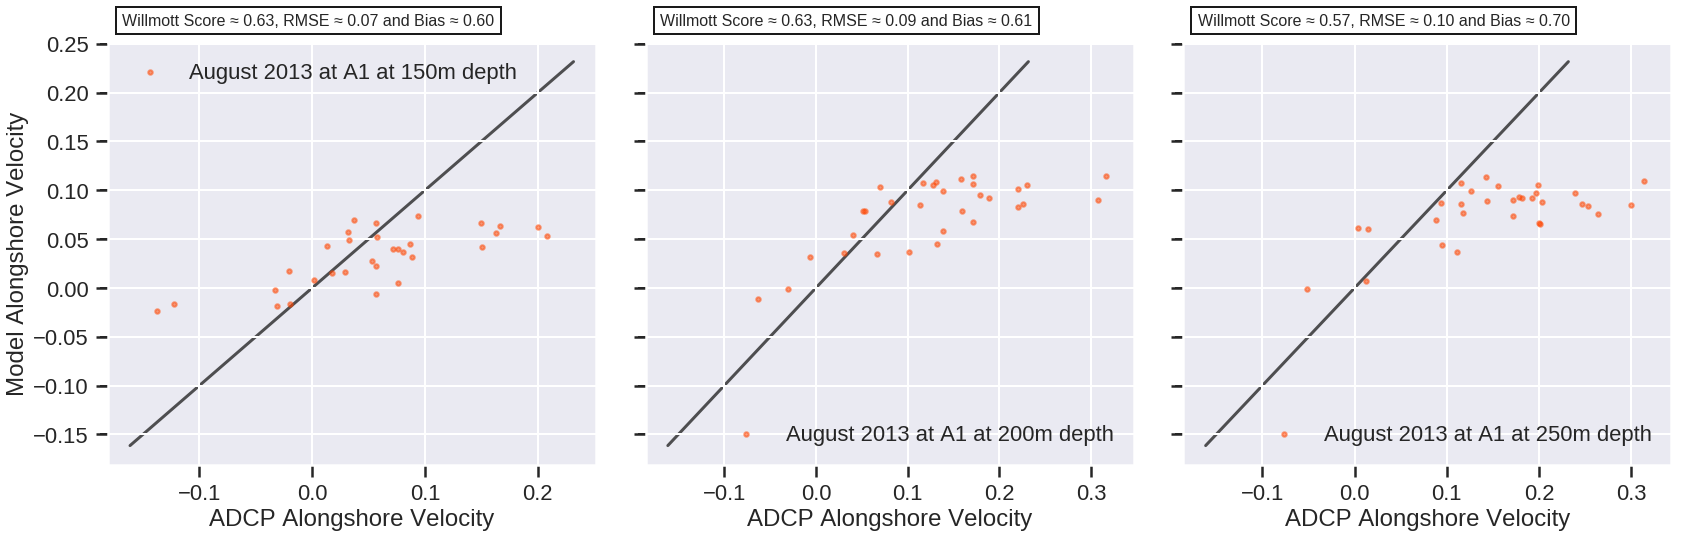

In [43]:
sns.set_context('poster')


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24, 8), sharey= True)

#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=150, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax1, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 150m depth')


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax1.legend()

ax1.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax1.transAxes
                       )
ax1.add_artist(anchored_text)



#For the first axis at 200m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=200, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax2, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 200m depth')


# lims = [
#     np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
#     np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
# ]

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax2.legend()

ax2.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax2.transAxes
                       )
ax2.add_artist(anchored_text)


#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=250, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax3, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 250m depth')


# lims = [
#     np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
#     np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
# ]

ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax3.legend()

ax3.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax3.transAxes
                       )
ax3.add_artist(anchored_text)

fig.tight_layout()



***Real Data has much more variability than the model : Model is much more uniform in terms of simulating the v velocity***

## Let us do the same for all the dates for like 3 months

## August and September

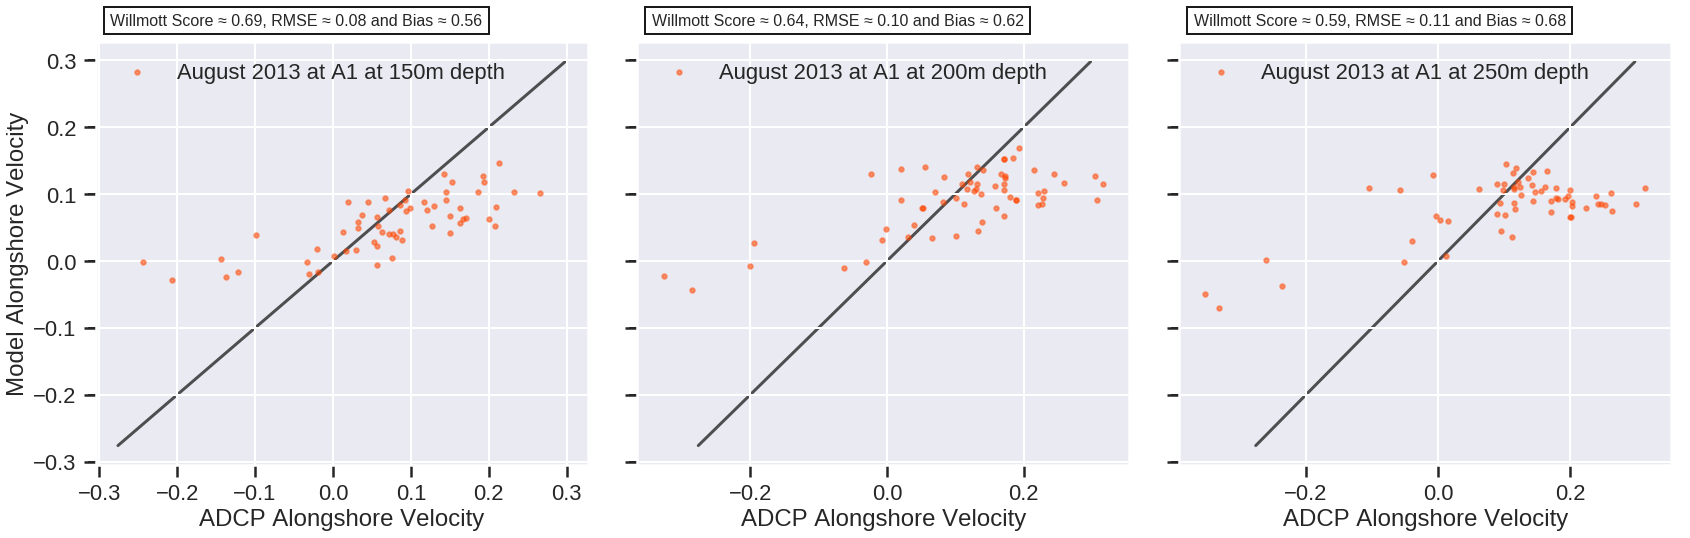

In [89]:
sns.set_context('poster')


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24, 8), sharey= True)

#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=150, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax1, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 150m depth')


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax1.legend()

ax1.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax1.transAxes
                       )
ax1.add_artist(anchored_text)



#For the first axis at 200m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=200, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax2, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 200m depth')


# lims = [
#     np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
#     np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
# ]

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax2.legend()

ax2.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax2.transAxes
                       )
ax2.add_artist(anchored_text)


#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=250, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax3, c = 'orangered', alpha = 0.5, label='August 2013 at A1 at 250m depth')


# lims = [
#     np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
#     np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
# ]

ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax3.legend()

ax3.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax3.transAxes
                       )
ax3.add_artist(anchored_text)

fig.tight_layout()



## July (starting 7th July) , August and September

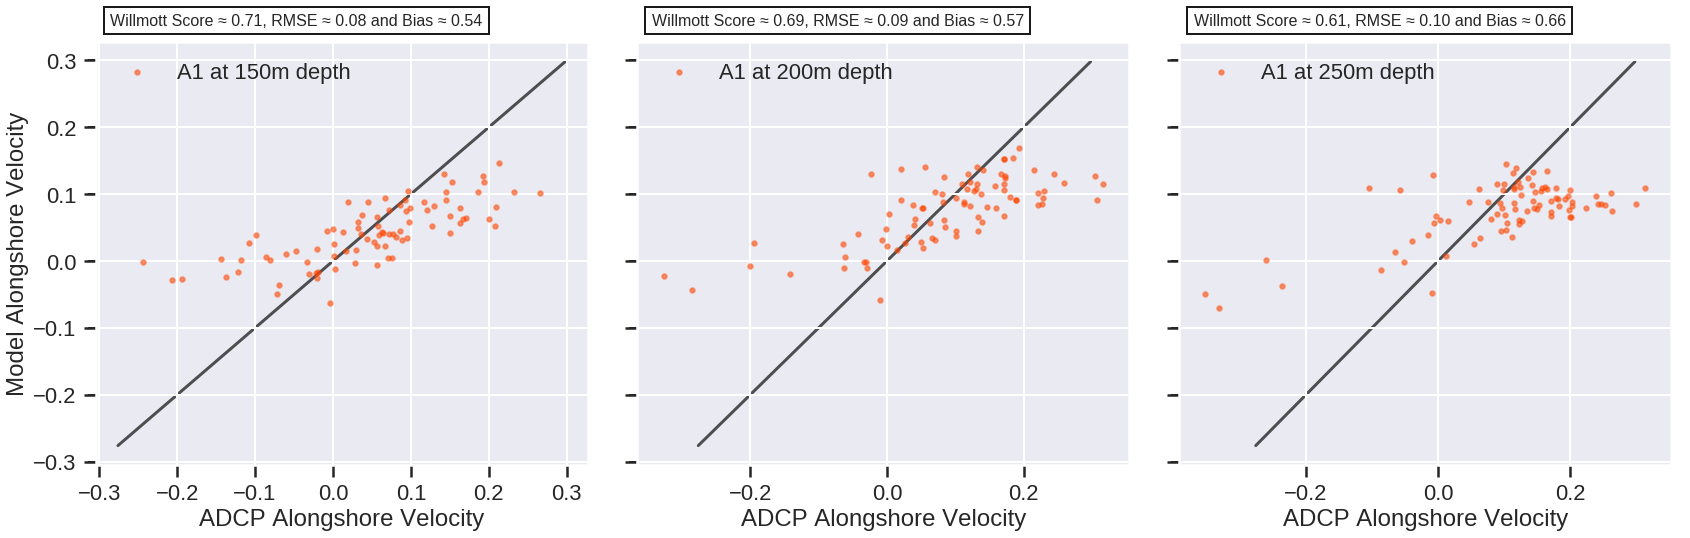

In [30]:
sns.set_context('poster')


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24, 8), sharey= True)

#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=150, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax1, c = 'orangered', alpha = 0.5, label='A1 at 150m depth')


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax1.legend()

ax1.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax1.transAxes
                       )
ax1.add_artist(anchored_text)



#For the first axis at 200m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=200, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax2, c = 'orangered', alpha = 0.5, label='A1 at 200m depth')


# lims = [
#     np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
#     np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
# ]

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax2.legend()

ax2.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax2.transAxes
                       )
ax2.add_artist(anchored_text)


#For the first axis at 150m

adcp_depth, model_depth = add_alongshore_data_to_depth_level(depth=250, model_depth_levels=zlevels,\
                                                             obs_depth_levels=z_ADCP,\
                                                             v_vel_adcp =north_ADCP_A_1_august,\
                                                            v_vel_model = north_NEP_august)

df = pd.DataFrame()

df['Model Alongshore Velocity'] = model_depth
df['ADCP Alongshore Velocity']  = adcp_depth

df.plot.scatter(x='ADCP Alongshore Velocity', y='Model Alongshore Velocity', \
                ax = ax3, c = 'orangered', alpha = 0.5, label='A1 at 250m depth')


# lims = [
#     np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
#     np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
# ]

ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax3.legend()

ax3.legend(loc = 'best')

gamma2,rms_error,ws = get_stat_tem(obs_data=df['ADCP Alongshore Velocity'], model_data=df['Model Alongshore Velocity'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),\
                             prop=dict(size=16), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax3.transAxes
                       )
ax3.add_artist(anchored_text)

fig.tight_layout()



### The model does a better job above the shelf break than the slope

## Taking a look at the wind conditions existing during the Falkor Cruise

In [265]:
La_Peruse_data = pd.read_table('/data/ssahu/Falkor_2013/winds/La_persue_wave_buoy.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

STN_ID        DATE   TIME LATITUDE LONGITUDE  DEPTH  VCAR   VTPK  \
217132  C46206  06/18/2018  18:38    48.83    126.00  72.00  2.19  12.80   
217133  C46206  06/18/2018  19:38    48.83    126.00  72.00  2.04  12.80   
217134  C46206  06/19/2018  00:38    48.83    126.00  72.00  1.76  12.19   
217135  C46206  06/19/2018  04:38    48.83    126.00  72.00  1.66  12.19   
217136  C46206  06/19/2018  05:38    48.83    126.00  72.00  1.51  12.19   
217137  C46206  06/19/2018  06:38    48.83    126.00  72.00  1.59  11.13   
217138  C46206  06/19/2018  13:38    48.83    126.00  72.00  1.51  11.64   
217139  C46206  06/19/2018  17:38    48.83    126.00  72.00  1.50  11.13   
217140  C46206  06/19/2018  18:38    48.83    126.00  72.00  1.45  15.06   
217141  C46206  06/19/2018  21:38    48.83    126.00  72.00  1.47  10.67   

         VWH  VCMX    VTP    WDIR  WSPD         Date_time  
217132  2.20  6.40  12.80   58.00  3.50  06/18/2018 18:38  
217133  2.00  3.80  12.80   64.00  3.70  06/18/2018 19:38  
217134  1.80  2.60  12.20  155.00  2.60  06/19/2018 00:38  
217135  1.70  2.70  12.20   86.00  2.60  06/19/2018 04:38  
217136  1.50  2.40  12.20   65.00  3.50  06/19/2018 05:38  
217137  1.60  2.80  11.10   64.00  4.80  06/19/2018 06:38  
217138  1.40  7.10  11.60   51.00  4.60  06/19/2018 13:38  
217139  1.30  7.00  11.10   72.00  4.20  06/19/2018 17:38  
217140  1.40  5.20  15.10   84.00  3.40  06/19/2018 18:38  
217141  1.50  2.10  10.70   87.00  2.50  06/19/2018 21:38

In [266]:
LA_PERUSE_array = df_cut.as_matrix()

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2013')))[-1,0]


In [267]:
wind_spd = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

In [268]:
def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]



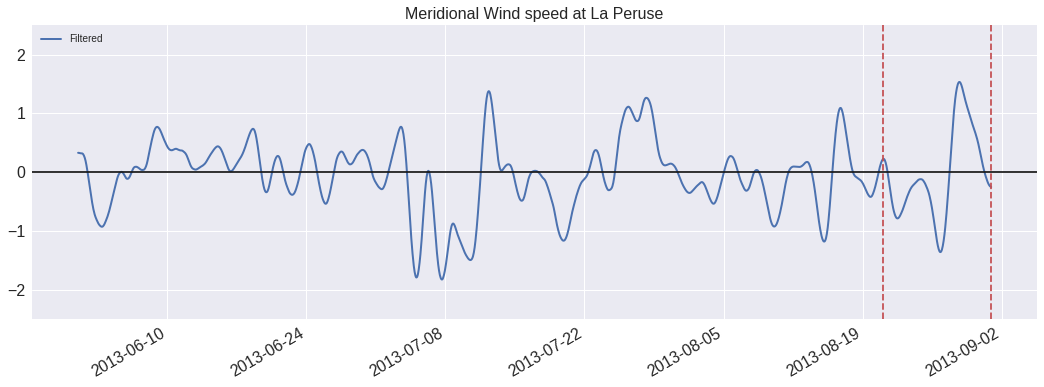

In [271]:

step = 1
window_size_1 = 72
window_size_2 = 1



time_axis = datetime_2013[::step]

time_axis_orford = datetime_2013_orford[::step]





s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')



s_v_orford = v_wind_orford[::step]   
filt_v_orford = smooth(s_v_orford,window_size_2,'hanning')


s_u_orford = u_wind_orford[::step]   
filt_u_orford = smooth(s_u_orford, window_size_2,'hanning')

s_wind_orford = wind_spd_orford[::step]
filt_wind_orford = smooth(s_wind_orford,window_size_2,'hanning')

fig,ax1 = plt.subplots(1, 1, figsize=(18,6))

ax1.plot(time_axis ,filt_v[::step], 'b-',linewidth=2)
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at La Peruse", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
fig.autofmt_xdate()



In [251]:
orford_data = pd.read_table('/data/ssahu/Falkor_2013/winds/port_orford_oregon.csv', delim_whitespace=1, parse_dates= True, header = None, skiprows=2)

# a = orford_data[0].str.split(',', expand=True)

# b = orford_data[1].str.split(',', expand=True)

# df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = orford_data.drop(orford_data.columns[6:], axis=1)
columns = ['Year','Month','Day','Hour','Wind Direction (deg)','Wind Speed','GDR','GST','GTIME']
effective = columns[:6]
df_cut.columns = effective


df_cut['Year']   = df_cut['Year'].astype(str)
df_cut['Day']    = df_cut['Day'].astype(str)
df_cut['Month']  = df_cut['Month'].astype(str)
df_cut['Hour']   = df_cut["Hour"].astype(str)

df_cut.columns = df_cut.columns.str.replace(' ', '')



df_cut['Datetime'] = df_cut['Year'] + "-" + df_cut['Month'] + "-" + df_cut['Day']+ " " + df_cut["Hour"] + ":00:00"

df_cut["Datetime"] = pd.to_datetime(df_cut["Datetime"])


df_cut = df_cut.iloc[:,4:]

df_cut = df_cut.set_index(pd.DatetimeIndex(df_cut["Datetime"]))


# df_cut.tail(10)

df_subset = df_cut.loc['2013-06-01 00:00:00':'2013-09-01 00:00:00']

df_subset = df_subset.resample('60T').mean().reset_index()
df_subset.head(10)

Datetime  WindDirection(deg)   WindSpeed
0 2013-06-01 00:00:00                25.0  351.666667
1 2013-06-01 01:00:00                25.0  356.833333
2 2013-06-01 02:00:00                25.0  355.333333
3 2013-06-01 03:00:00                25.0  354.166667
4 2013-06-01 04:00:00                25.0  355.333333
5 2013-06-01 05:00:00                25.0  355.666667
6 2013-06-01 06:00:00                25.0  355.666667
7 2013-06-01 07:00:00                25.0  349.333333
8 2013-06-01 08:00:00                25.0  350.166667
9 2013-06-01 09:00:00                25.0  350.833333

In [257]:
wind_spd_orford = df_subset["WindSpeed"].astype(np.float)

wind_dir_orford = df_subset["WindDirection(deg)"].astype(np.float)

v_wind_orford = np.empty_like(wind_dir_orford)

# for i in np.arange(wind_dir_orford.shape[0]):
#     v_wind_orford[i] = np.multiply(wind_spd_orford[i],np.sin(wind_dir_orford))
    
    
    

u_wind_orford = np.multiply(wind_spd_orford[:],np.cos(wind_dir_orford[:]))
# u_wind_orford = u_wind_orford.resample('60T').mean()

v_wind_orford = np.multiply(wind_spd_orford[:],np.sin(wind_dir_orford[:]))
# v_wind_orford = v_wind_orford.resample('60T').mean()



time_2013_orford = df_subset["Datetime"].astype(str)

datetime_2013_orford = np.empty_like(time_2013_orford)

for i in np.arange(datetime_2013_orford.shape[0]):
    datetime_2013_orford[i] = datetime.strptime(time_2013_orford[i], '%Y-%m-%d %H:%M:%S')
    
datetime_2013_orford = datetime_2013_orford.astype(np.datetime64)

In [256]:
np.min(v_wind_orford)

-47.624571410181993

In [249]:
df_subset = df_subset.resample('60T').mean().reset_index()

In [250]:
df_subset.head(10)

Datetime  WindDirection(deg)   WindSpeed
0 2013-06-01 00:00:00                25.0  351.666667
1 2013-06-01 01:00:00                25.0  356.833333
2 2013-06-01 02:00:00                25.0  355.333333
3 2013-06-01 03:00:00                25.0  354.166667
4 2013-06-01 04:00:00                25.0  355.333333
5 2013-06-01 05:00:00                25.0  355.666667
6 2013-06-01 06:00:00                25.0  355.666667
7 2013-06-01 07:00:00                25.0  349.333333
8 2013-06-01 08:00:00                25.0  350.166667
9 2013-06-01 09:00:00                25.0  350.833333

In [263]:
df_subset.tail(10)

Datetime  WindDirection(deg)   WindSpeed
2199 2013-08-31 15:00:00                25.0   71.666667
2200 2013-08-31 16:00:00                25.0   94.333333
2201 2013-08-31 17:00:00                25.0   95.166667
2202 2013-08-31 18:00:00                25.0  118.333333
2203 2013-08-31 19:00:00                25.0  167.166667
2204 2013-08-31 20:00:00                25.0  120.666667
2205 2013-08-31 21:00:00                25.0  139.666667
2206 2013-08-31 22:00:00                25.0   85.833333
2207 2013-08-31 23:00:00                25.0   92.500000
2208 2013-09-01 00:00:00                25.0  179.000000